# Social graphs project: Taylor swift network and analysis

Students:
- Raquel Chaves Martinez (s243297)
- Paula Gambus i Moreno ((s233219))
- Alessia Saccardo (s212246)

In this notebook we will build and analyze a Taylor Swift song Network. This file will be structured as follows:
1. <a href="#data">Data Collection and Analysis</a>
    1. <a href="#ts-data">Taylor Swift dataset analysis</a>
    1. <a href="#web-scrapping">Metacritic Web Scrapping</a>
1. <a href="#network">Network Construction</a>
    1. <a href="#song-simmilarity">Song Similarity with TF-IDF</a>
    1. <a href="#network-creation">Network Creation</a>
1. <a href="#network-analysis">Network Analysis</a>
    1. <a href="#degree">Degree, In-Degree, and Out-Degree Distributions</a>
    1. <a href="#community-detection">Community Detection</a>
    1. <a href="#centrality">Centrality analysis</a>
1. <a href="#sentiment">Sentiment Analysis</a>
    1. <a href="#sentiment-evaluation">LabMT Wordlist Sentiment Evaluation</a>
    1. <a href="#sentiment-distribution">Sentiment Distribution Visualization</a>
1. <a href="#popularity">Popularity and Critical Reception</a>
    1. <a href="#correlation-streams-sentiment">Spotify Streams vs. Sentiment Scores</a>
    1. <a href="#correlation-streams-metacritic">Spotify Streams vs. Metacritic Scores</a>
    1. <a href="#correlation-rereleased">Original vs. "Taylor’s Version" Albums</a>

### Necessary packages

In [1]:
# Standard library imports
import json
import os
import pickle
import re
import string
import sys
import textwrap
import warnings
from collections import Counter, defaultdict

# Suppress warnings
warnings.filterwarnings("ignore")

# Data processing and manipulation
import numpy as np
import pandas as pd

# Text processing and natural language processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, RegexpTokenizer
import contractions

# Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from wordcloud import WordCloud  # Uncomment if needed

# Web scraping and HTTP requests
import requests
from bs4 import BeautifulSoup

# Machine learning and text mining
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Graphs and networks
import networkx as nx
import community.community_louvain as community_louvain


In [2]:
# Download NLTK stop words
#nltk.download('stopwords')

<a id='data'></a>
## Data Collection and Analysis

<a id='ts-data'></a>
### Taylor Swift dataset Analysis

In [3]:
data = pd.read_csv('data/taylor_swift_discography_updated.csv', sep=';', index_col = 'ID')
ts_data = data.copy() # Remove dots in spotify streams

In [4]:
#print size of the dataset
rows, columns = ts_data.shape
print('Number of rows: ', rows)
print('Number of columns: ', columns)

Number of rows:  577
Number of columns:  27


In [5]:
# print name of columns
print(ts_data.columns)

Index(['track_name', 'track_musical_genre', 'track_type', 'duration_ms',
       'feature', 'track_videoclip', 'videoclip_views', 'spotify_streams',
       'spotify_global_peak', 'album', 'track_number', 'album_musical_genre',
       'album_type', 'release_date', 'album_physical_sales', 'track_lyrics',
       'track_theme', 'uri', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence'],
      dtype='object')


In [6]:
#print the number of albums
print('Number of albums:', ts_data['album'].nunique())
#print the name of the unique albums
print('Titles:', ts_data['album'].unique())

Number of albums: 29
Titles: ['The Tortured Poets Department: The Anthology'
 'The Tortured Poets Department' "1989 (Taylor's Version) [Deluxe]"
 "1989 (Taylor's Version)" "Speak Now (Taylor's Version)"
 'Midnights (The Til Dawn Edition)' 'Midnights (3am Edition)' 'Midnights'
 "Red (Taylor's Version)" "Fearless (Taylor's Version)"
 'evermore (deluxe version)' 'evermore'
 'folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]'
 'folklore (deluxe version)' 'folklore' 'Lover' 'reputation'
 'reputation Stadium Tour Surprise Song Playlist' '1989 (Deluxe Edition)'
 '1989' 'Red (Deluxe Edition)' 'Red' 'Speak Now World Tour Live'
 'Speak Now (Deluxe Edition)' 'Speak Now' 'Fearless Platinum Edition'
 'Fearless' 'Live From Clear Channel Stripped 2008' 'Taylor Swift']


In [7]:
# change the type of certain columns of the dataset
ts_data['release_date'] = pd.to_datetime(ts_data['release_date'], format='%d/%m/%Y')
ts_data['spotify_streams'] = ts_data['spotify_streams'].str.replace('.', '')
ts_data['spotify_streams'] = pd.to_numeric(ts_data['spotify_streams'], errors='coerce')

Firstly, we should do some analysis to know how the dataset is and what can we investigate. We would like to know more about the streams so we generate some plots.

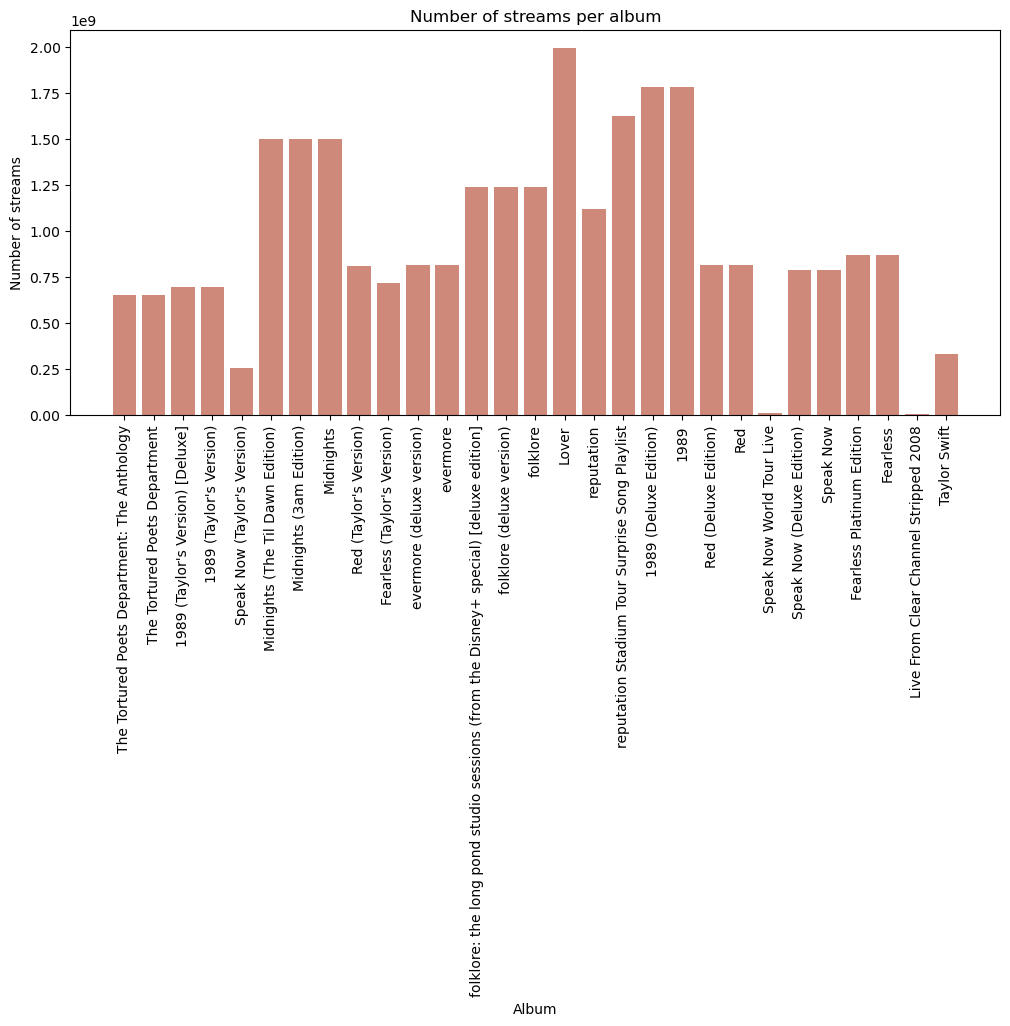

In [8]:
plt.figure(figsize=(12, 5))
plt.bar(ts_data['album'], ts_data['spotify_streams'], color='#cf897a')  # Darker pink color
plt.xticks(rotation=90)
plt.title('Number of streams per album')
plt.ylabel('Number of streams')
plt.xlabel('Album')
plt.tight_layout() 
plt.show()

From the previous plot we can see that the albums that are "Live" are the ones with lower stream numbers. The "Lover" original album is the one with more popularity, and this might be because it is the only version she released of it. Also, we can observe that all the "Midnight" albums have more or less the same number of streams.

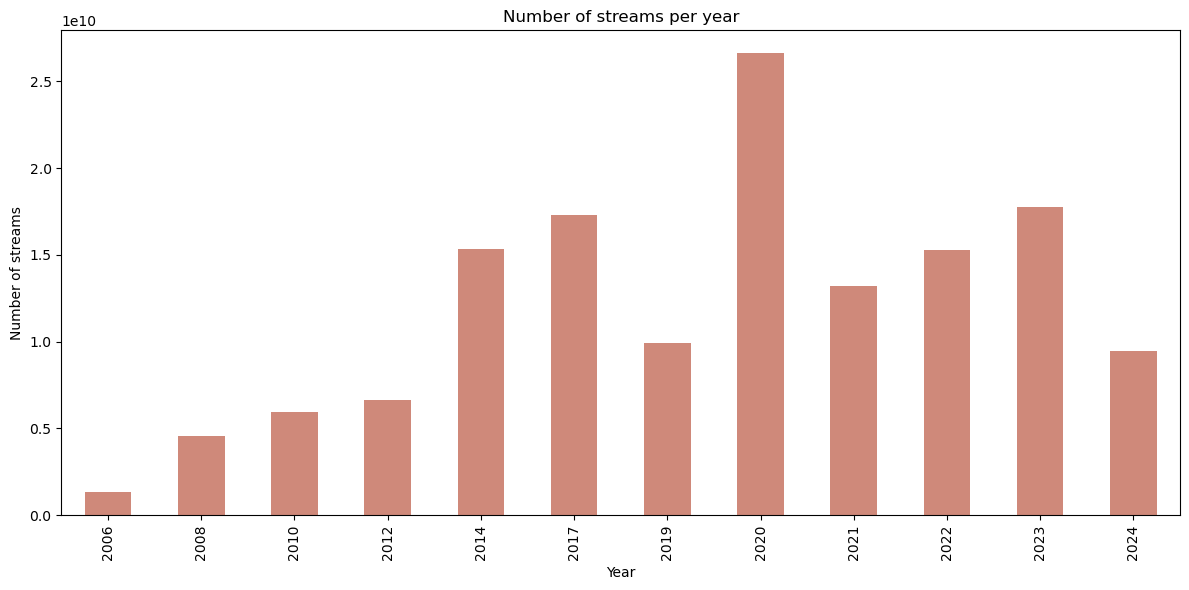

In [9]:
# average of streams per year taking into account how many songs were released that year
plt.figure(figsize=(12, 6))
ts_data.groupby(ts_data['release_date'].dt.year)['spotify_streams'].sum().plot(kind='bar', color='#cf897a')  # Darker pink color
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Number of streams')
plt.title('Number of streams per year')
plt.tight_layout()  # Adjust layout to prevent cutting off labels
plt.show()

The year with more Spotify streams is in the 2020 that is when she released two new albums *Folklore* and *Evermore*. In 2017, the number of streams are also high because she released *Reputation* album, three years after her last released album *1989*. In 2023, she also had a high number of streams considering that she did a re-released of two of her most famous albums *Speak Now (Taylor's Version)* and *1989 (Taylor's Version)*.

We also want to know more about the genres that Taylor Swift sings and how many songs per album she released.

Number of genres: 18
['Synth Pop' 'R&B' 'Pop Rock' 'Indie Rock' 'Indie Pop' 'Folk Pop'
 'Electropop' 'Country Pop' 'Dance Pop' 'Dream Pop' 'Pop' 'Pop Rock '
 'Alternative Rock' 'Indie Folk' 'Pop  ' 'Funk Pop' 'Country' 'Country  ']


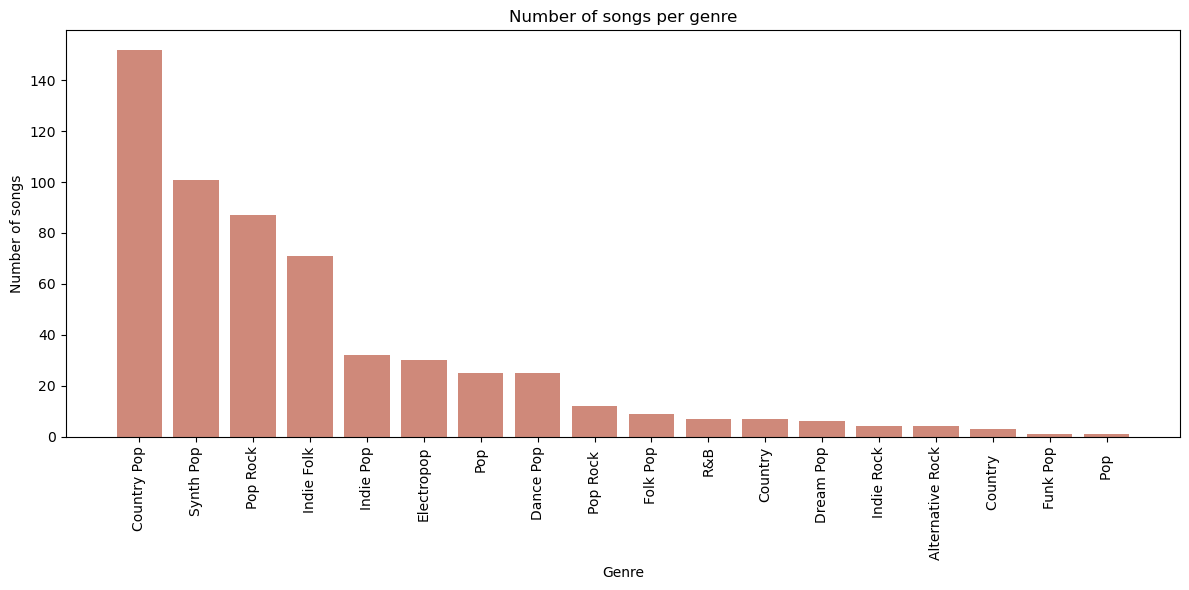

In [10]:
# how many genres and list them
print('Number of genres:', ts_data['track_musical_genre'].nunique())
print(ts_data['track_musical_genre'].unique())

# number of songs per genre plot
plt.figure(figsize=(12, 6))
plt.bar(ts_data['track_musical_genre'].value_counts().index, ts_data['track_musical_genre'].value_counts().values, color='#cf897a')  # Darker pink color
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of songs')
plt.title('Number of songs per genre')
plt.tight_layout()  # Adjust layout to prevent cutting off labels
plt.show()

Everyone has always been saying that Taylor Swift's genre is **country** and here we have the proof that most of her songs are **Country Pop**. However, she also sings **Synth Pop** and **PopRock**. Her least common genres are **Pop** and **Funk Pop**.

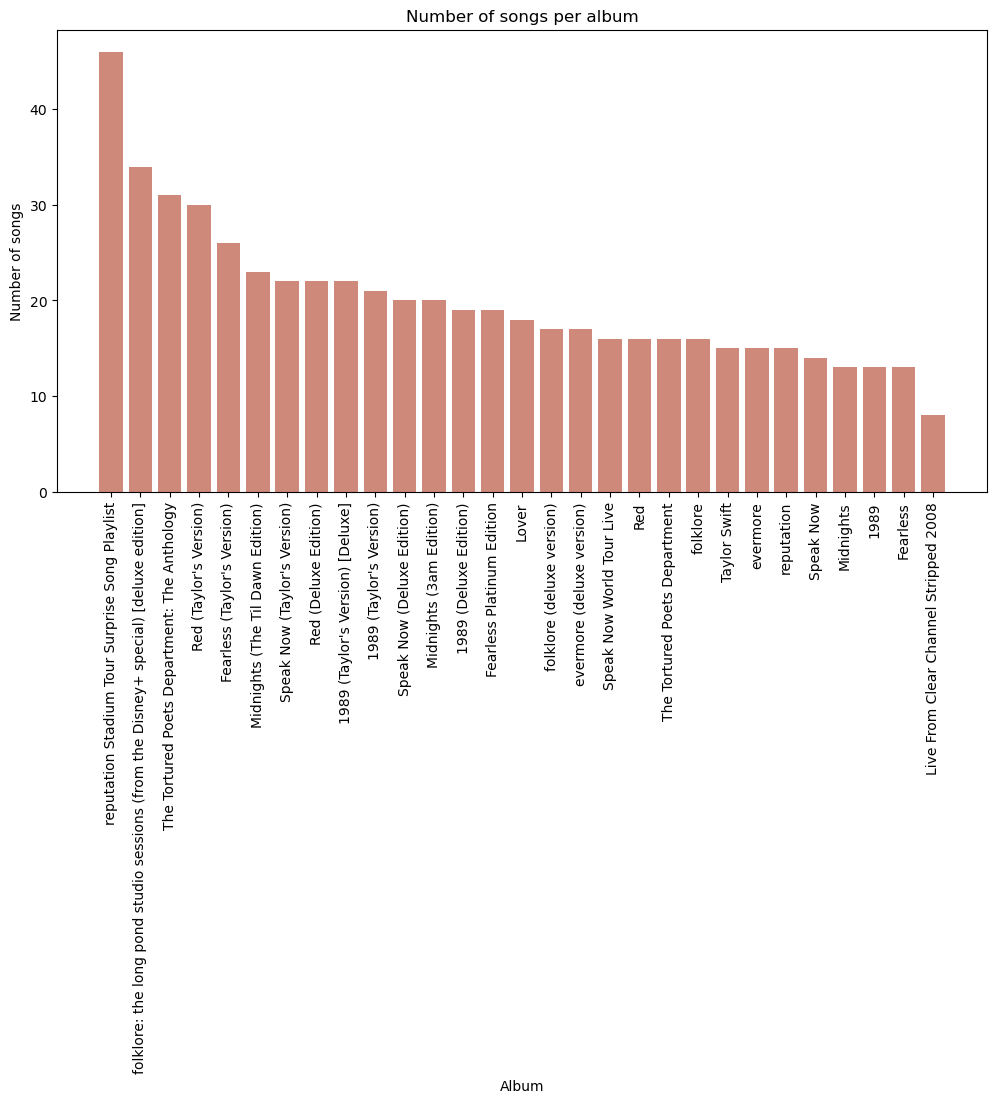

In [11]:
# number of songs per album
plt.figure(figsize=(12, 6))
plt.bar(ts_data['album'].value_counts().index, ts_data['album'].value_counts().values, color='#cf897a')  # Darker pink color
plt.xticks(rotation=90)
plt.xlabel('Album')
plt.ylabel('Number of songs')
plt.title('Number of songs per album')
plt.tight_layout()  # Adjust layout to prevent cutting off labels
plt.show()

In this plot, we can see that most of the albums have a similar number of songs. However, the Stadium Tour Surprise Song Playlist has a significant higher amount of songs, and this is due to the fact that includes all the songs that she performed during that tour.

Knowing the background of Taylor Swift and that she re-released some songs, we analyze if there are duplicated songs in our dataset.

In [12]:
# check which songs are repeated and how many times
repeated_songs = ts_data['track_name'].value_counts()
repeated_songs_2 = repeated_songs[repeated_songs == 2]
repeated_songs_3 = repeated_songs[repeated_songs == 3]

print('This number of songs were repeated:', len(repeated_songs_2) + len(repeated_songs_3))
print('This number of songs were released twice:', len(repeated_songs_2))
print('This number of songs werec released three times:', len(repeated_songs_3))

This number of songs were repeated: 156
This number of songs were released twice: 96
This number of songs werec released three times: 60


We realized that as we thought, some songs are repeated twice or even three times in our dataset. Therefore, let's print for each song the number of times it appears and the total number of songs repeated twice or three times.

To deal with these duplicated songs we start by merging those that appear with exacty the same name in the dataset.

In [13]:
def merge_rows_with_same_name(df, key_column='track_name'):
    # Group by the key_column
    grouped = df.groupby(key_column)

    def merge_values(series):
        unique_values = series.dropna().unique()
        if len(unique_values) == 1:
            return unique_values[0]
        else:
            return list(unique_values)

    merged_df = grouped.agg({col: merge_values for col in df.columns if col != key_column}).reset_index()
    
    return merged_df

In [14]:
ts_data = merge_rows_with_same_name(ts_data)

These types of duplicates have now been removed. Later, we will need to address additional released songs whose names appear different in the dataset but have identical lyrics.

In [15]:
print(ts_data['track_name'].value_counts())
print(ts_data.shape)

track_name
willow                                         1
"Slut!" (Taylor's Version) (From The Vault)    1
...Ready For It?                               1
22                                             1
22 (Taylor's Version)                          1
                                              ..
Anti-Hero                                      1
Babe                                           1
Babe (Taylor's Version) (From The Vault)       1
Back To December                               1
Back To December (Taylor's Version)            1
Name: count, Length: 361, dtype: int64
(361, 27)


In [16]:
# Flatten the 'album' column if it contains lists
flattened_albums = ts_data['album'].explode()  # Explodes lists into separate rows
unique_albums = flattened_albums.dropna().unique()
print(unique_albums)

["1989 (Taylor's Version) [Deluxe]" "1989 (Taylor's Version)" 'reputation'
 'reputation Stadium Tour Surprise Song Playlist' 'Red (Deluxe Edition)'
 'Red' "Red (Taylor's Version)" 'Taylor Swift' 'Lover'
 '1989 (Deluxe Edition)' '1989' 'Midnights (The Til Dawn Edition)'
 'Midnights (3am Edition)' 'Midnights' 'Speak Now (Deluxe Edition)'
 'Speak Now' "Speak Now (Taylor's Version)" 'Speak Now World Tour Live'
 'Live From Clear Channel Stripped 2008' 'Fearless Platinum Edition'
 'Fearless' "Fearless (Taylor's Version)"
 'The Tortured Poets Department: The Anthology'
 'The Tortured Poets Department'
 'folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]'
 'folklore (deluxe version)' 'folklore' 'evermore (deluxe version)'
 'evermore']


In [17]:
# Remove live album because we don't have critics on it and some songs don't have lyrics
ts_data = ts_data[ts_data['album'] != 'Speak Now World Tour Live']

<a id='web-scrapping'></a>
### Metacritic web scrapping

With the aim of enlarging our Taylor Swift discography analysis, we decided to analyze the review of her albums. To do so, we did web scraping of the Metacritic web page.

First we need to get the links to the pages that will allow us to scrape the desired information.

In [18]:
links = [
'https://www.metacritic.com/music/taylor-swift/taylor-swift',
'https://www.metacritic.com/music/1989/taylor-swift', 
'https://www.metacritic.com/music/fearless/taylor-swift', 
'https://www.metacritic.com/music/speak-now/taylor-swift', 
'https://www.metacritic.com/music/red/taylor-swift', 
'https://www.metacritic.com/music/reputation/taylor-swift', 
'https://www.metacritic.com/music/lover/taylor-swift',
'https://www.metacritic.com/music/folklore/taylor-swift',
'https://www.metacritic.com/music/evermore/taylor-swift',
'https://www.metacritic.com/music/fearless-taylors-version/taylor-swift',
'https://www.metacritic.com/music/red-taylors-version/taylor-swift',
'https://www.metacritic.com/music/midnights/taylor-swift',
'https://www.metacritic.com/music/speak-now-taylors-version/taylor-swift',
'https://www.metacritic.com/music/1989-taylors-version/taylor-swift',
'https://www.metacritic.com/music/the-tortured-poets-department/taylor-swift',
'https://www.metacritic.com/music/the-tortured-poets-department-the-anthology/taylor-swift']

We then built a function that returns the source, score and summary of each review.

In [19]:
def scrape_metacritic_reviews(url, n_critics):
    """
    Function that extracts the critic reviews from a Metacritic page.
    url: str, the URL of the Metacritic page of the album reviews
    n_critics: int, the number of critics to extract
    """
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to fetch {url} with status code {response.status_code}")
        return None
    
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract all sources
    critic_sources = []
    source_div = soup.find_all("div", class_="source")
    for source in source_div:
        source_name = source.find("a").text.strip() if source.find("a") else "Source Not Found"
        #print(source_name)
        critic_sources.append(str(source_name))
    
    # Extract all critic scores
    critic_scores = []
    review_grade_divs = soup.find_all("div", class_="review_grade")
    for review_grade in review_grade_divs:
        score = review_grade.find("div", class_="metascore_w")
        if score:
            critic_scores.append(int(score.text.strip()))

    # Extract all review bodies
    review_bodies = []
    review_body_divs = soup.find_all("div", class_="review_body")
    for review_body in review_body_divs:
        body = review_body.text.strip() if review_body else "No Review Body"
        review_bodies.append(str(body))

    
    # only keep the information of the first n_critics (those corresponding to the critics' reviews)
    critic_scores = critic_scores[:n_critics]
    review_bodies = review_bodies[:n_critics]
    # make a new list of tuples (critic_score, review_body)
    critic_reviews = list(zip(critic_sources, critic_scores, review_bodies))

    return critic_reviews

We also defined a function that takes the album url and extracts the link to the review pages. This function returns the album and the reviews.

In [20]:
# Function to scrape album data from Metacritic
def scrape_metacritic_album(url):
    """
    This function takes the album url and returns the album title, number of critics and reviews.
    url: str, the URL of the Metacritic page of the album
    """

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to fetch {url} with status code {response.status_code}")
        return None
    
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract album title
    title = soup.find("h1").text.strip() if soup.find("h1") else "Title Not Found"
    print(title)

    # Extract Metascore
    metascore = soup.find("span", itemprop="ratingValue").text.strip() if soup.find("span", class_="metascore_w") else "No Metascore"
    #print(metascore)
    
    n_critics = soup.find("span", itemprop="reviewCount").text.strip() if soup.find("span", itemprop="reviewCount") else "No Critic Count"
    n_critics = int(n_critics.split()[0])
    
    # Extract review link from metascore_anchor class
    review_link_tag = soup.find("a", class_="metascore_anchor")
    review_link = review_link_tag['href'] if review_link_tag and review_link_tag.has_attr('href') else None
    if review_link:
        review_link = f"https://www.metacritic.com{review_link}"
        #print(review_link)

    reviews = scrape_metacritic_reviews(review_link, n_critics)

    # Return the extracted data
    return {
        "title": title,
        "number of critics": n_critics,
        "reviews": reviews,
    }

The last function that we build related to the web scrapping is the one that allows us to save the data in .csv files.

In [21]:
def save_album_data_to_csv(data):
    """
    This function is used to save the album data to a CSV file.
    data: dict, a dictionary containing the album data
    """
    # Clean the album title for file naming
    title = data["title"].replace(" ", "_").replace("/", "_")

    # Create a DataFrame from the reviews
    df = pd.DataFrame(data["reviews"], columns=["source","score", "review"])

    # Define output directory and file path
    output_dir = "./data/album_reviews"
    os.makedirs(output_dir, exist_ok=True)
    csv_path = os.path.join(output_dir, f"{title}.csv")

    # Save DataFrame to CSV
    df.to_csv(csv_path, index=False)
    print(f"Saved data for album '{data['title']}' to {csv_path}")

Finally, we obtain the files with the reviews and save them.

In [22]:
for link in links:
    review_data = scrape_metacritic_album(link)
    save_album_data_to_csv(review_data)

Taylor Swift
Saved data for album 'Taylor Swift' to ./data/album_reviews/Taylor_Swift.csv
1989
Saved data for album '1989' to ./data/album_reviews/1989.csv
Fearless
Saved data for album 'Fearless' to ./data/album_reviews/Fearless.csv
Speak Now
Saved data for album 'Speak Now' to ./data/album_reviews/Speak_Now.csv
Red
Saved data for album 'Red' to ./data/album_reviews/Red.csv
reputation
Saved data for album 'reputation' to ./data/album_reviews/reputation.csv
Lover
Saved data for album 'Lover' to ./data/album_reviews/Lover.csv
folklore
Saved data for album 'folklore' to ./data/album_reviews/folklore.csv
evermore
Saved data for album 'evermore' to ./data/album_reviews/evermore.csv
Fearless (Taylor's Version)
Saved data for album 'Fearless (Taylor's Version)' to ./data/album_reviews/Fearless_(Taylor's_Version).csv
Red (Taylor's Version)
Saved data for album 'Red (Taylor's Version)' to ./data/album_reviews/Red_(Taylor's_Version).csv
Midnights
Saved data for album 'Midnights' to ./data/album

<a id='network'></a>
## Network construction

To build the network, we represented songs as nodes and connected them with **directed edges** based on their **lyrical similarity**. A directed edge was added between two songs if they shared a certain number of common words, as determined by their tf-idf scores. The edges were directed to capture the chronological relationship, linking earlier released songs to later ones. This design reflects our hypothesis that earlier songs might have inspired subsequent releases, allowing us to observe potential patterns of influence over time.

To ensure the accuracy of network connections based on lyrics similarity, we put significant effort in text processing and cleaning.

In [23]:
def clean_text(text):
    # If the input is a list, join elements into a single string
    if isinstance(text, list):
        text = ' '.join(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Expand contractions (e.g., "I'm" -> "I am")
    text = contractions.fix(text)
    
    # Remove text enclosed in square brackets, like [Verse 1: Taylor Swift]
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Lemmatization (convert words to their root form)
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    
    return text



In [24]:
# Apply text cleaning
ts_data['cleaned_lyrics'] = ts_data['track_lyrics'].apply(clean_text)

# Display the cleaned data
ts_data[['track_name', 'cleaned_lyrics']].head()

track_name  \
0  "Slut!" (Taylor's Version) (From The Vault)   
1                             ...Ready For It?   
2                                           22   
3                        22 (Taylor's Version)   
4                       A Perfectly Good Heart   

                                      cleaned_lyrics  
0  flamingo pink sunrise boulevard clink clink yo...  
1  knew killer first time saw wondered many girl ...  
2  feel like perfect night dress like hipster mak...  
3  feel like perfect night dress like hipster mak...  
4  would want break perfectly good heart would wa...

<a id='song-simmilarity'></a>
### Song similarity with TF-IDF

Now we will compute the cosine similarity between songs based on the TF-IDF score.

In [25]:
def compute_tfidf_similarity(data, text_column, index_column):
    """
    Compute TF-IDF scores and a similarity matrix for a dataset.

    Parameters:
    - data (pd.DataFrame): The input dataset.
    - text_column (str): The column containing text data for TF-IDF computation.
    - index_column (str): The column to use as the index for similarity and TF-IDF DataFrames.

    Returns:
    - tfidf_df (pd.DataFrame): DataFrame of TF-IDF scores.
    - similarity_df (pd.DataFrame): Pairwise similarity matrix based on cosine similarity.
    """
    # Step 1: Calculate TF-IDF scores
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(data[text_column])

    # Step 2: Get feature names (words) from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Step 3: Convert the TF-IDF matrix to a DataFrame
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=feature_names,
        index=data[index_column]
    )

    # Step 4: Compute the similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Step 5: Convert the similarity matrix to a DataFrame
    similarity_df = pd.DataFrame(
        similarity_matrix,
        index=data[index_column],
        columns=data[index_column]
    )

    # Return both TF-IDF and similarity DataFrames
    return tfidf_df, similarity_df

In [26]:
# Compute TF-IDF and similarity matrix for the dataset
tfidf_df, similarity_df = compute_tfidf_similarity(
    data=ts_data,
    text_column='cleaned_lyrics',
    index_column='track_name'
)

# Display a sample of the TF-IDF and similarity matrices
print("TF-IDF DataFrame:")
print(tfidf_df.shape)
tfidf_df.head()

TF-IDF DataFrame:
(345, 4303)


158  16th   17  1830s  1944  \
track_name                                                                 
"Slut!" (Taylor's Version) (From The Vault)  0.0   0.0  0.0    0.0   0.0   
...Ready For It?                             0.0   0.0  0.0    0.0   0.0   
22                                           0.0   0.0  0.0    0.0   0.0   
22 (Taylor's Version)                        0.0   0.0  0.0    0.0   0.0   
A Perfectly Good Heart                       0.0   0.0  0.0    0.0   0.0   

                                             1950s  1958  2003  230   25  ...  \
track_name                                                                ...   
"Slut!" (Taylor's Version) (From The Vault)    0.0   0.0   0.0  0.0  0.0  ...   
...Ready For It?                               0.0   0.0   0.0  0.0  0.0  ...   
22                                             0.0   0.0   0.0  0.0  0.0  ...   
22 (Taylor's Version)                          0.0   0.0   0.0  0.0  0.0  ...   
A Perfectly Good Heart                         0.0   0.0   0.0  0.0  0.0  ...   

                                                  you  youi     young  \
track_name                                                              
"Slut!" (Taylor's Version) (From The Vault)  0.022968   0.0  0.048119   
...Ready For It?                             0.048531   0.0  0.000000   
22                                           0.040954   0.0  0.000000   
22 (Taylor's Version)                        0.040954   0.0  0.000000   
A Perfectly Good Heart                       0.000000   0.0  0.000000   

                                              younger  youplease  your  yours  \
track_name                                                                      
"Slut!" (Taylor's Version) (From The Vault)  0.000000        0.0   0.0    0.0   
...Ready For It?                             0.052495        0.0   0.0    0.0   
22                                           0.000000        0.0   0.0    0.0   
22 (Taylor's Version)                        0.000000        0.0   0.0    0.0   
A Perfectly Good Heart                       0.000000        0.0   0.0    0.0   

                                             yourself  youth  zlister  
track_name                                                             
"Slut!" (Taylor's Version) (From The Vault)       0.0    0.0      0.0  
...Ready For It?                                  0.0    0.0      0.0  
22                                                0.0    0.0      0.0  
22 (Taylor's Version)                             0.0    0.0      0.0  
A Perfectly Good Heart                            0.0    0.0      0.0  

[5 rows x 4303 columns]

In [27]:
print("Similarity Matrix:")
print(similarity_df.shape)
similarity_df.head(10)

Similarity Matrix:
(345, 345)


track_name                                          "Slut!" (Taylor's Version) (From The Vault)  \
track_name                                                                                        
"Slut!" (Taylor's Version) (From The Vault)                                            1.000000   
...Ready For It?                                                                       0.039831   
22                                                                                     0.025628   
22 (Taylor's Version)                                                                  0.025628   
A Perfectly Good Heart                                                                 0.035435   
A Place in this World                                                                  0.039183   
Afterglow                                                                              0.084422   
All Too Well                                                                           0.121836   
All Too Well (10 Minute Version) (Taylor's Vers...                                     0.116570   
All Too Well (Taylor's Version)                                                        0.121836   

track_name                                          ...Ready For It?  \
track_name                                                             
"Slut!" (Taylor's Version) (From The Vault)                 0.039831   
...Ready For It?                                            1.000000   
22                                                          0.061747   
22 (Taylor's Version)                                       0.061747   
A Perfectly Good Heart                                      0.036758   
A Place in this World                                       0.078595   
Afterglow                                                   0.058289   
All Too Well                                                0.063346   
All Too Well (10 Minute Version) (Taylor's Vers...          0.044343   
All Too Well (Taylor's Version)                             0.063346   

track_name                                                22  \
track_name                                                     
"Slut!" (Taylor's Version) (From The Vault)         0.025628   
...Ready For It?                                    0.061747   
22                                                  1.000000   
22 (Taylor's Version)                               1.000000   
A Perfectly Good Heart                              0.025080   
A Place in this World                               0.083865   
Afterglow                                           0.087050   
All Too Well                                        0.078212   
All Too Well (10 Minute Version) (Taylor's Vers...  0.054785   
All Too Well (Taylor's Version)                     0.078212   

track_name                                          22 (Taylor's Version)  \
track_name                                                                  
"Slut!" (Taylor's Version) (From The Vault)                      0.025628   
...Ready For It?                                                 0.061747   
22                                                               1.000000   
22 (Taylor's Version)                                            1.000000   
A Perfectly Good Heart                                           0.025080   
A Place in this World                                            0.083865   
Afterglow                                                        0.087050   
All Too Well                                                     0.078212   
All Too Well (10 Minute Version) (Taylor's Vers...               0.054785   
All Too Well (Taylor's Version)                                  0.078212   

track_name                                          A Perfectly Good Heart  \
track_name                                                                   
"Slut!" (Taylor's Version) (From The Vault)                       0.035435   
...Ready For It?  

By examining the similarity matrix, we can observe that duplicate songs still exist, specifically, songs that appear under different track names but have a similarity score of 1, indicating that their lyrics are identical.  

First, we define a similarity threshold (0.97) to identify song pairs with nearly identical lyrics. The similarity matrix is iterated to find pairs exceeding this threshold, excluding self-comparisons. These pairs, along with their similarity scores, are stored in a DataFrame to later be processed. A helper function, `merge_rows`, is used to merge attributes of duplicate rows, resolving conflicting values by either keeping a single value when identical or combining them into a list when they differ. The merging function, `merge_high_similarity_rows`, iterates through the identified high-similarity pairs (store in the dataset mentioned above), locates the corresponding rows in the dataset, and merges them, using the shortest track name as the canonical name for the merged record. The original rows are removed, and the merged row is added to the updated dataset.

In [28]:
similarity_threshold = 0.97

# Initialize a set to store the pairs
high_similarity_pairs = set()

# Iterate through the similarity matrix
for song1 in similarity_df.index:
    for song2 in similarity_df.columns:
        # Exclude self-similarity and check if the score exceeds the threshold
        if song1 != song2 and similarity_df.at[song1, song2] > similarity_threshold:
            # Add the pair to the set (ensuring each pair is unique)
            pair = tuple(sorted((song1, song2)))
            high_similarity_pairs.add((pair[0], pair[1], similarity_df.at[song1, song2]))

# Convert the set to a DataFrame
high_similarity_df = pd.DataFrame(high_similarity_pairs, columns=["Song1", "Song2", "Similarity"])
print(high_similarity_df.shape)
high_similarity_df.head(50)


(133, 3)


Song1  \
0                                    I Wish You Would   
1                                               betty   
2                                      Wildest Dreams   
3                          Haunted (Taylor's Version)   
4                                               Clean   
5                                          Love Story   
6                                    Forever & Always   
7                                         Begin Again   
8                                            Innocent   
9          I Knew You Were Trouble (Taylor's Version)   
10                                    The Story Of Us   
11                                The Way I Loved You   
12                     Blank Space (Taylor's Version)   
13                                             Change   
14  Mr. Perfectly Fine (Taylor's Version) (From Th...   
15                                       Shake It Off   
16                                     State Of Grace   
17                                           epiphany   
18                                               hoax   
19                                          Starlight   
20                I Wish You Would (Taylor's Version)   
21                                     State Of Grace   
22                         All You Had To Do Was Stay   
23                                               Ours   
24                                          Enchanted   
25                                                Red   
26             Miss Americana & The Heartbreak Prince   
27                            Mine (Taylor's Version)   
28                                              the 1   
29                                        Blank Space   
30                Back To December (Taylor's Version)   
31                                   Out Of The Woods   
32                                Welcome To New York   
33  Forever & Always (Piano Version) (Taylor's Ver...   
34                                   Forever & Always   
35                                Better Than Revenge   
36                                          mad woman   
37                                       Girl At Home   
38                                          Long Live   
39                      Love Story (Taylor's Version)   
40            We Are Never Ever Getting Back Together   
41  Forever & Always (Piano Version) (Taylor's Ver...   
42                                    illicit affairs   
43                                         Wonderland   
44             Miss Americana & The Heartbreak Prince   
45                                  Should've Said No   
46                                              seven   
47                                              Style   
48                   I Know Places (Taylor's Version)   
49                                        Holy Ground   

                                                Song2  Similarity  
0                       I Wish You Would - Voice Memo         1.0  
1               betty - the long pond studio sessions         1.0  
2                   Wildest Dreams (Taylor's Version)         1.0  
3                          Haunted - Acoustic Version         1.0  
4                            Clean (Taylor's Version)         1.0  
5                       Love Story (Taylor's Version)         1.0  
6                    Forever & Always - Piano Version         1.0  
7                      Begin Again (Taylor's Version)         1.0  
8                         Innocent (Taylor's Version)         1.0  
9                            I Knew You Were Trouble.         1.0  
10                 The Story Of Us (Taylor's Version)         1.0  
11             The Way I Loved You (Taylor's Version)         1.0  
12                           Blank Space - Voice Memo         1.0  
13                          Change (Taylor's Version)         1.0  
14                                         mirrorball         1.0  
15                    Shake It Off (Taylor's Version

In [29]:
def merge_rows(row1, row2, columns):
    """
    Merges two rows by comparing column values.
    If values differ, save as a list; otherwise, keep a single value.
    Handles cases where fields might already be lists.
    """
    merged_row = {}
    for col in columns:
        values = []
        for value in [row1[col], row2[col]]:
            if isinstance(value, list):
                values.extend(value)  # Extend if already a list
            else:
                values.append(value)  # Append single values
        
        # Ensure values are unique and check for pre-existing lists
        unique_values = pd.Series(values).dropna().unique()
        # If only one unique value exists, keep it; otherwise, store as a list
        merged_row[col] = unique_values[0] if len(unique_values) == 1 else list(unique_values)
    return merged_row

# Function to merge the dataset based on high similarity pairs
def merge_high_similarity_rows(dataset, high_similarity_df):
    # Copy the dataset to avoid modifying the original
    updated_dataset = dataset.copy()
    columns = dataset.columns.tolist()
    
    for _, (song1, song2, _) in high_similarity_df.iterrows():
        # Find the rows corresponding to the pair
        row1 = updated_dataset.loc[updated_dataset['track_name'] == song1]
        row2 = updated_dataset.loc[updated_dataset['track_name'] == song2]
        
        if not row1.empty and not row2.empty:
            row1 = row1.iloc[0]
            row2 = row2.iloc[0]
            
            # Determine the shortest track name
            shortest_name = song1 if len(song1) <= len(song2) else song2
            
            # Merge the two rows
            merged_row = merge_rows(row1, row2, columns)
            merged_row['track_name'] = shortest_name  # Set the shortest name as the track name
            
            # Remove the original rows
            updated_dataset = updated_dataset[~updated_dataset['track_name'].isin([song1, song2])]
            
            # Add the merged row
            updated_dataset = pd.concat([updated_dataset, pd.DataFrame([merged_row])], ignore_index=True)
    
    return updated_dataset

# Apply the merging function to the dataset
updated_ts_data = merge_high_similarity_rows(ts_data, high_similarity_df)
updated_ts_data.head()

track_name track_musical_genre track_type  \
0  "Slut!" (Taylor's Version) (From The Vault)           Synth Pop     Single   
1                             ...Ready For It?          Electropop     Single   
2                       A Perfectly Good Heart         Country Pop     B-Side   
3                        A Place in this World         Country Pop     B-Side   
4                                    Afterglow                 Pop     B-Side   

        duration_ms feature track_videoclip videoclip_views spotify_streams  \
0            180381      No              No               0       239579759   
1            208186      No             Yes     350.707.005       695895392   
2            220146      No              No               0        25204096   
3  [202080, 199200]      No              No               0        40680546   
4            223293      No              No               0       368409481   

  spotify_global_peak                                              album  ...  \
0                   2  [1989 (Taylor's Version) [Deluxe], 1989 (Taylo...  ...   
1                   3                                         reputation  ...   
2                   0                                       Taylor Swift  ...   
3                   0  [reputation Stadium Tour Surprise Song Playlis...  ...   
4                  38                                              Lover  ...   

      acousticness    danceability          energy      instrumentalness  \
0   [0.309, 0.345]  [0.591, 0.629]  [0.412, 0.413]  [0.000199, 7.62e-05]   
1           0.0527           0.613           0.764                   0.0   
2          0.00349           0.483           0.751                   0.0   
3  [0.0577, 0.051]  [0.573, 0.576]  [0.767, 0.777]                   0.0   
4             0.13           0.756           0.449                   0.0   

           liveness           loudness       speechiness               tempo  \
0  [0.0608, 0.0603]  [-13.27, -13.178]   [0.0863, 0.055]   [155.875, 77.983]   
1             0.197             -6.509             0.136             160.015   
2             0.128             -5.726            0.0365             156.092   
3     [0.327, 0.32]   [-2.929, -2.881]  [0.0323, 0.0324]  [114.984, 115.028]   
4             0.114             -8.746            0.0344             111.011   

          valence                                     cleaned_lyrics  
0  [0.328, 0.306]  flamingo pink sunrise boulevard clink clink yo...  
1           0.417  knew killer first time saw wondered many girl ...  
2           0.268  would want break perfectly good heart would wa...  
3  [0.438, 0.428]  know want ask still trying figure know road wa...  
4           0.399  blew thing proportion blue put jail something ...  

[5 rows x 28 columns]

With this updated dataset free of duplicates, we can recompute the similarity matrix and tf-idf scores to proceed with building the network.

In [30]:
# Compute TF-IDF and similarity matrix for the dataset
tfidf_df, similarity_df = compute_tfidf_similarity(
    data=updated_ts_data,
    text_column='cleaned_lyrics',
    index_column='track_name'
)

Each node represents a song and includes attributes such as release date, genre, Spotify streams, and album. An edge is created between two songs if they share at least 3 words from their 20 most common words. The edges are directed, pointing from the older song to the newer one. When visualizing the network, the size of each node is proportional to its number of Spotify streams.

In [31]:
def extract_top_words(tfidf_df, top_n=10):
    """
    Extracts the top N highest-scoring words for each song from the TF-IDF DataFrame.

    Parameters:
        tfidf_df (DataFrame): The TF-IDF DataFrame with songs as rows and words as columns.
        top_n (int): The number of top words to extract for each song.

    Returns:
        DataFrame: A DataFrame with 'track_name' and 'top_words' columns.
    """
    top_words = []

    # Iterate over each song in the TF-IDF DataFrame
    for track_name, row in tfidf_df.iterrows():
        # Get the top N words with the highest TF-IDF scores
        top_word_indices = row.nlargest(top_n).index
        top_word_scores = row.nlargest(top_n).values
        words_with_scores = [(word, score) for word, score in zip(top_word_indices, top_word_scores)]
        
        # Append the song and its top words to the list
        top_words.append({
            'track_name': track_name,
            'top_words': words_with_scores
        })

    # Convert the list to a DataFrame
    top_words_df = pd.DataFrame(top_words)
    return top_words_df

# Extract top 20 words for each song
top_words_df = extract_top_words(tfidf_df, top_n=20)
top_words_df.head()


track_name  \
0  "Slut!" (Taylor's Version) (From The Vault)   
1                             ...Ready For It?   
2                       A Perfectly Good Heart   
3                        A Place in this World   
4                                    Afterglow   

                                           top_words  
0  [(might, 0.3569688448161781), (slut, 0.3053722...  
1  [(begin, 0.5379038688265549), (game, 0.3842918...  
2  [(perfectly, 0.42725262582385404), (want, 0.40...  
3  [(oh, 0.41883244597634794), (own, 0.3845367444...  
4  [(want, 0.3663974890957303), (lose, 0.32328300...

<a id='net-creation'></a>
### Network creation

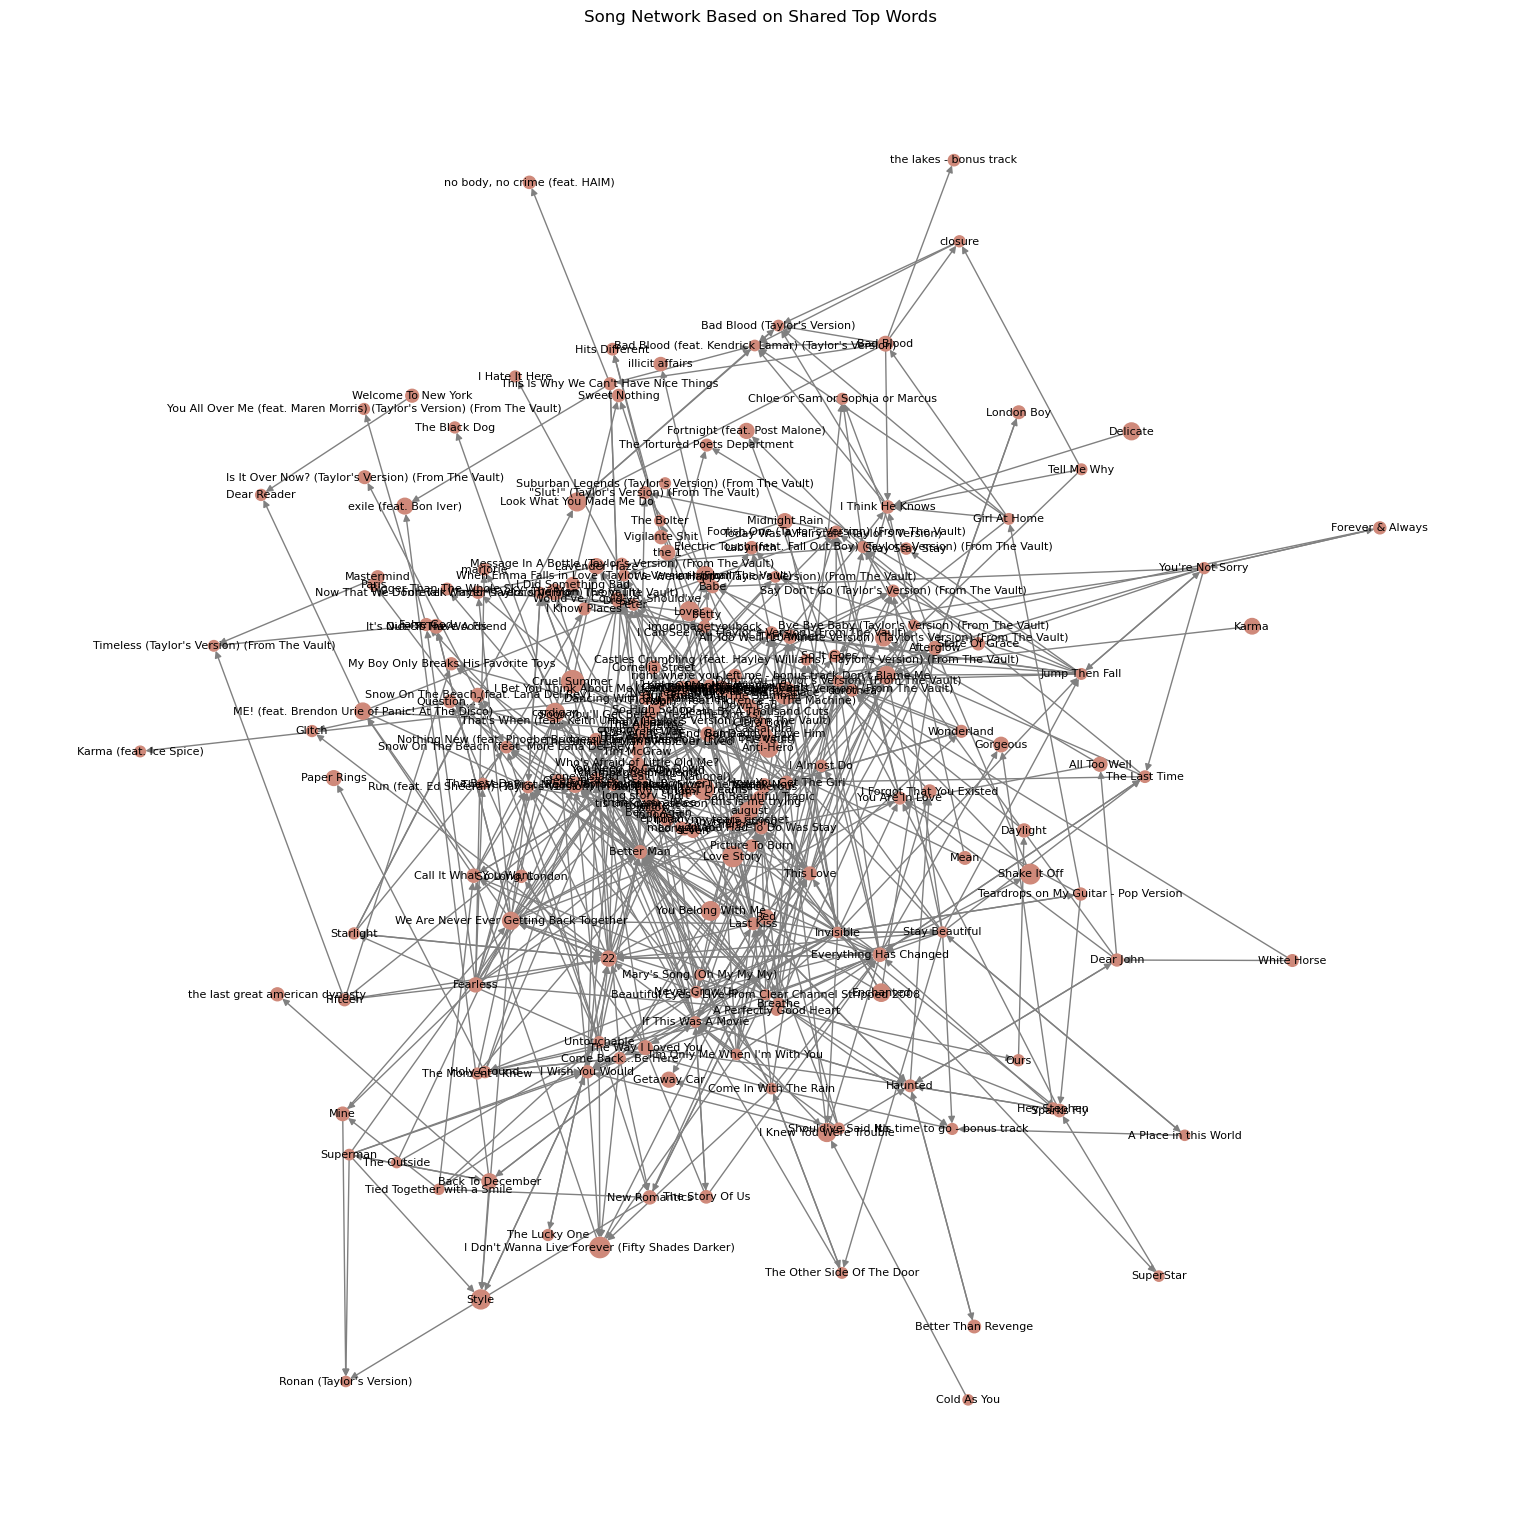

Number of nodes: 235
Number of edges: 496


In [32]:
def build_song_network(ts_data, top_words_df, min_shared_words=1):
    """
    Builds a directed song network based on shared top words and release dates.

    Parameters:
        ts_data (DataFrame): The original dataset with song metadata, including release dates.
        top_words_df (DataFrame): DataFrame containing track names and their top words.
        min_shared_words (int): Minimum number of shared words required to create an edge.

    Returns:
        nx.DiGraph: A directed network of songs.
    """
    G = nx.DiGraph()

    # Build a mapping of song to top words
    song_to_words = dict(zip(top_words_df['track_name'], top_words_df['top_words']))

    # Add nodes to the graph
    for _, row in ts_data.iterrows():
        G.add_node(
            row['track_name'], 
            release_date=row['release_date'],
            genre=row['track_musical_genre'], 
            spotify_streams=row['spotify_streams'],
            album = row['album']
        )

    # Add edges based on shared words and release dates
    for song1, words1 in song_to_words.items():
        for song2, words2 in song_to_words.items():
            if song1 != song2:
                # Find common words between the two songs
                common_words = set([w[0] for w in words1]).intersection([w[0] for w in words2])
                if len(common_words) >= min_shared_words:
                    # Determine the direction of the edge based on release date
                    date1 = ts_data.loc[ts_data['track_name'] == song1, 'release_date'].iloc[0]
                    date2 = ts_data.loc[ts_data['track_name'] == song2, 'release_date'].iloc[0]

                    # Handle lists in release_date
                    if isinstance(date1, list):
                        date1 = min(date1)
                    if isinstance(date2, list):
                        date2 = min(date2)

                    # Add edge based on release date comparison
                    if date1 < date2:
                        G.add_edge(song1, song2, weight=len(common_words))
                    else:
                        G.add_edge(song2, song1, weight=len(common_words))

    return G

# Build the song network
net = build_song_network(updated_ts_data, top_words_df, min_shared_words=3)

node_sizes = []
for node in net.nodes:
    streams = net.nodes[node]['spotify_streams']
    if isinstance(streams, list):
        # If spotify_streams is a list, sum the values
        node_sizes.append(sum(streams))
    else:
        # If it's a single value, just append it
        node_sizes.append(streams)

# Normalize the node sizes to make them visually appropriate
max_streams = max(node_sizes)
min_streams = min(node_sizes)
normalized_sizes = [50 + (size - min_streams) / (max_streams - min_streams) * 200 for size in node_sizes]

plt.figure(figsize=(15, 15))
pos = nx.kamada_kawai_layout(net)  
nx.draw(
    net, pos, with_labels=True, 
    node_size=normalized_sizes, node_color = '#cf897a', font_size=8, edge_color="gray", arrowsize=10
)
plt.title("Song Network Based on Shared Top Words")
plt.show()

# Display network statistics
print(f"Number of nodes: {net.number_of_nodes()}")
print(f"Number of edges: {net.number_of_edges()}")


The resulted network contains 235 nodes and 496 edges

In [33]:
# Code to save network and dataframe if necessary
# with open('song_network.pkl', 'wb') as f:
#     pickle.dump(net, f)

# updated_ts_data.to_pickle("ts_data.pkl")
# print("DataFrame saved as 'updated_ts_data.pkl'")

<a id='network-analysis'></a>
## Network Analysis

In this section, we will analyze the network, focusing on the degree distribution and comparing Louvain-based communities with album-based communities.

<a id='degree'></a>
### Degree, In-Degree, and Out-Degree Distributions

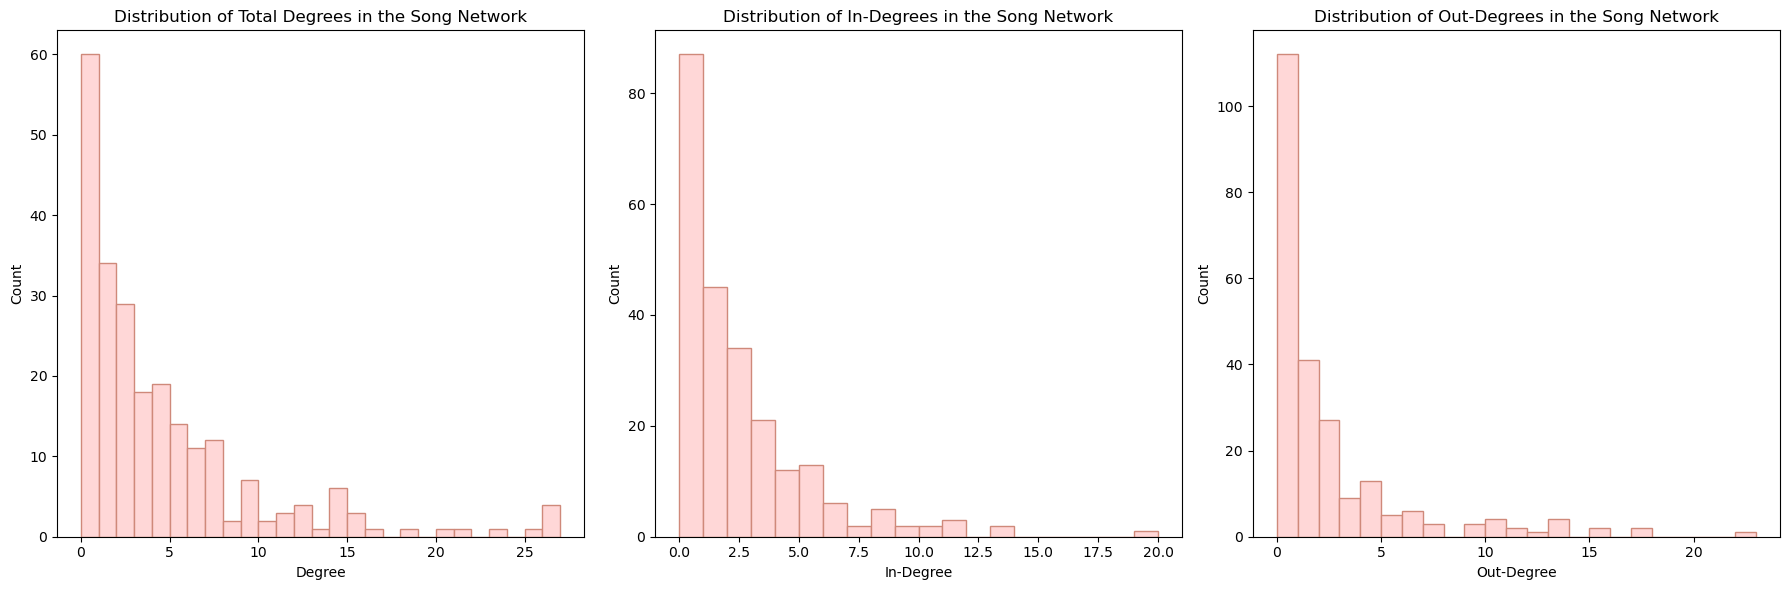

In [34]:
# Calculate degree, in-degree, and out-degree for each node
degrees = [d for n, d in net.degree()]
in_degrees = [d for n, d in net.in_degree()]
out_degrees = [d for n, d in net.out_degree()]

# Plot degree distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Total Degree Distribution
axes[0].hist(degrees, bins=range(0, max(degrees) + 1), color='#ffd7d7', edgecolor='#cf897a')
axes[0].set_title('Distribution of Total Degrees in the Song Network')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Count')

# In-Degree Distribution
axes[1].hist(in_degrees, bins=range(0, max(in_degrees) + 1), color='#ffd7d7', edgecolor='#cf897a')
axes[1].set_title('Distribution of In-Degrees in the Song Network')
axes[1].set_xlabel('In-Degree')
axes[1].set_ylabel('Count')

# Out-Degree Distribution
axes[2].hist(out_degrees, bins=range(0, max(out_degrees) + 1), color='#ffd7d7', edgecolor='#cf897a')
axes[2].set_title('Distribution of Out-Degrees in the Song Network')
axes[2].set_xlabel('Out-Degree')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()



The image shows the degree distributions within the song network, divided into three categories: total degree, in-degree, and out-degree. The total degree distribution (left) indicates that most songs have a low number of connections, while a few have significantly higher connectivity. The in-degree distribution (center) reveals that many songs receive few incoming connections, with a gradual decline as the in-degree increases, suggesting that only a few songs are highly influenced by others. Similarly, the out-degree distribution (right) shows that most songs have few outgoing connections, with a small number influencing a larger number of other songs. This pattern suggests that the network may exhibit characteristics of a scale-free structure, where a few highly connected nodes play a central role.

In [35]:
# Find the top 5 songs with the highest in-degree
top_in_degree = sorted(net.in_degree(), key=lambda x: x[1], reverse=True)[:5]
in_degree_table = [[song, degree] for song, degree in top_in_degree]

# Find the top 5 songs with the highest out-degree
top_out_degree = sorted(net.out_degree(), key=lambda x: x[1], reverse=True)[:5]
out_degree_table = [[song, degree] for song, degree in top_out_degree]

# Print tables
print("Top 5 Songs with Highest In-Degree (Most Influenced):")
print(tabulate(in_degree_table, headers=["Song", "In-Degree"], tablefmt="grid"))

print("\nTop 5 Songs with Highest Out-Degree (Most Influential):")
print(tabulate(out_degree_table, headers=["Song", "Out-Degree"], tablefmt="grid"))


Top 5 Songs with Highest In-Degree (Most Influenced):
+------------------------------------------------------------+-------------+
| Song                                                       |   In-Degree |
+============================================================+=============+
| The Very First Night (Taylor's Version) (From The Vault)   |          20 |
+------------------------------------------------------------+-------------+
| Don't You (Taylor's Version) (From The Vault)              |          13 |
+------------------------------------------------------------+-------------+
| Better Man                                                 |          13 |
+------------------------------------------------------------+-------------+
| Run (feat. Ed Sheeran) (Taylor's Version) (From The Vault) |          11 |
+------------------------------------------------------------+-------------+
| Everything Has Changed                                     |          11 |
+---------------------

<a id='community-detection'></a>
### Community Detection

<a id='louivan-communities'></a>
### Louvain communities

In [36]:
# Make graph undirected
undirected_net = net.to_undirected()

In [37]:
# Extract the Giant Connected Component (GCC)
largest_cc = max(nx.connected_components(undirected_net), key=len)
gcc = undirected_net.subgraph(largest_cc).copy()
print(f"GCC has {gcc.number_of_nodes()} nodes and {gcc.number_of_edges()} edges")

GCC has 173 nodes and 464 edges


In [38]:
# Detect communities in the GCC
# partition = community_louvain.best_partition(gcc, random_state=42)

# # Save the partition to ensure consistency
# with open("partition.pkl", "wb") as f:
#     pickle.dump(partition, f)

# Load partitions
with open("partition.pkl", "rb") as f:
    partition = pickle.load(f)

# Compute modularity for the GCC
modularity = community_louvain.modularity(partition, gcc)
print(f"Number of communities in GCC: {len(set(partition.values()))}")
print(f"Modularity value for GCC: {modularity}")

Number of communities in GCC: 9
Modularity value for GCC: 0.4877700531340194


The results from the Louvain community detection algorithm applied to the Giant Connected Component (GCC) of the network indicate that it has been divided into 9 distinct communities. The modularity value of 0.4877 suggests a moderately strong community structure. This value indicates that the detected communities are well-defined, with a higher-than-random proportion of edges existing within the communities compared to edges between them.

In [39]:
# Group nodes by community and name them after the song with highest degree
communities = defaultdict(list)
for node, comm_id in partition.items():
    communities[comm_id].append(node)

community_names = {}
for comm_id, nodes in communities.items():
    # Compute degree for each node in the community
    degrees = {node: undirected_net.degree(node) for node in nodes}
    # Find the node with the highest degree
    highest_degree_node = max(degrees, key=degrees.get)
    community_names[comm_id] = highest_degree_node

print("Communities named by highest-degree song:")
community_names


Communities named by highest-degree song:


{0: 'Invisible',
 1: 'Afterglow',
 2: 'Stay Beautiful',
 3: 'All You Had To Do Was Stay',
 4: 'I Think He Knows',
 5: 'Better Man',
 6: "The Very First Night (Taylor's Version) (From The Vault)",
 7: 'Untouchable',
 8: 'If This Was A Movie'}

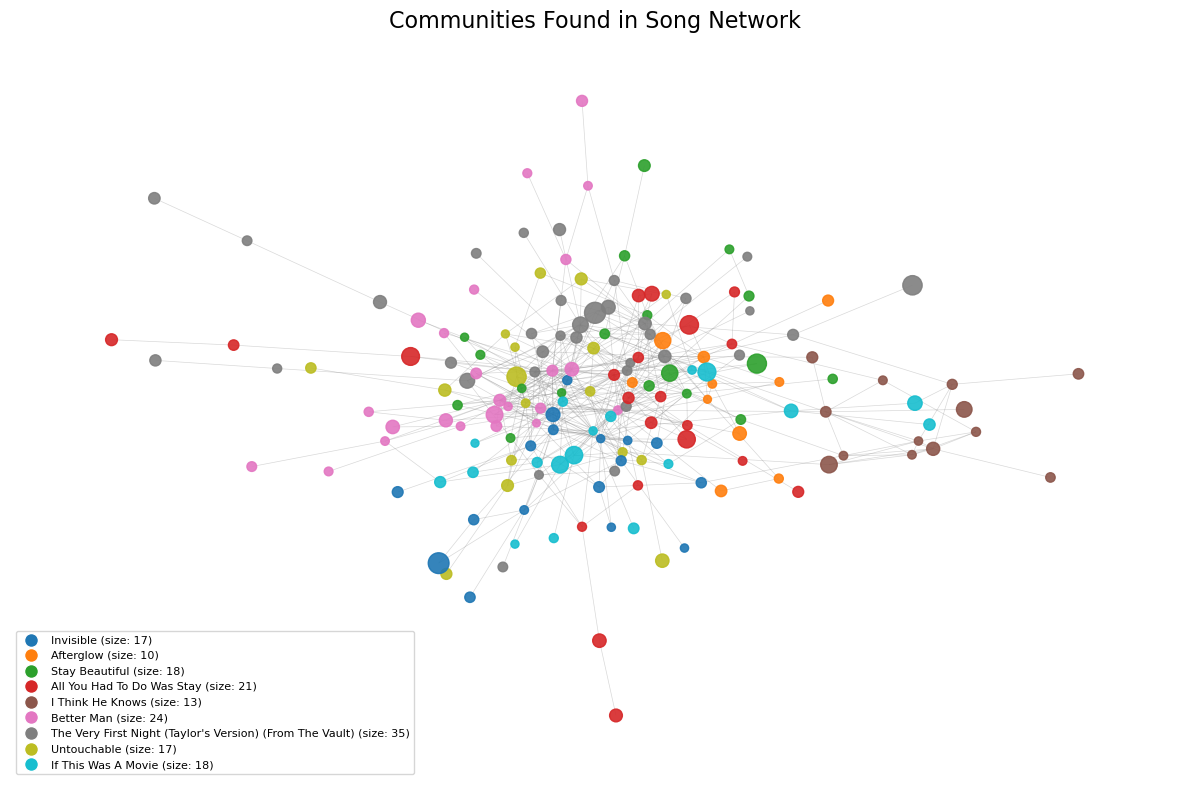

In [40]:
# Prepare a color map for communities
num_communities = len(communities)
colors = plt.get_cmap("tab10", num_communities)

# Assign a color to each node based on its community
node_colors = [colors(partition[node]) for node in gcc.nodes()]

# Assign node sizes based on Spotify streams (or degree if not available)
node_sizes = [
    30 + (sum(gcc.nodes[node].get("spotify_streams", [1])) / 1e7) 
    if isinstance(gcc.nodes[node].get("spotify_streams"), list)
    else 30 + (gcc.nodes[node].get("spotify_streams", 1) / 1e7) 
    for node in gcc.nodes()
]

# Compute layout
pos = nx.spring_layout(gcc, seed=42)  # Force-directed layout with a fixed seed for consistency

# Plot the graph
plt.figure(figsize=(12,8))
nx.draw_networkx_nodes(
    gcc,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    cmap="tab10",
    alpha=0.9
)
nx.draw_networkx_edges(
    gcc,
    pos,
    alpha=0.3,
    edge_color="gray",
    width=0.5
)

# Add a legend for communities
handles = []
for comm_id, name in community_names.items():
    handles.append(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=colors(comm_id),
            markersize=10,
            label=f"{name} (size: {len(communities[comm_id])})"
        )
    )
plt.legend(
    handles=handles,
    loc="lower left",             # Align the lower-left corner of the legend
    bbox_to_anchor=(0, 0),        # To the lower-left of the axes
    ncol=1,                       # Single-column legend
    frameon=True,                 # Show legend frame
    fontsize=8,                   # Set font size
)


# Finalize and show the plot
plt.title("Communities Found in Song Network", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


We will now generate and plot a word cloud for each community.

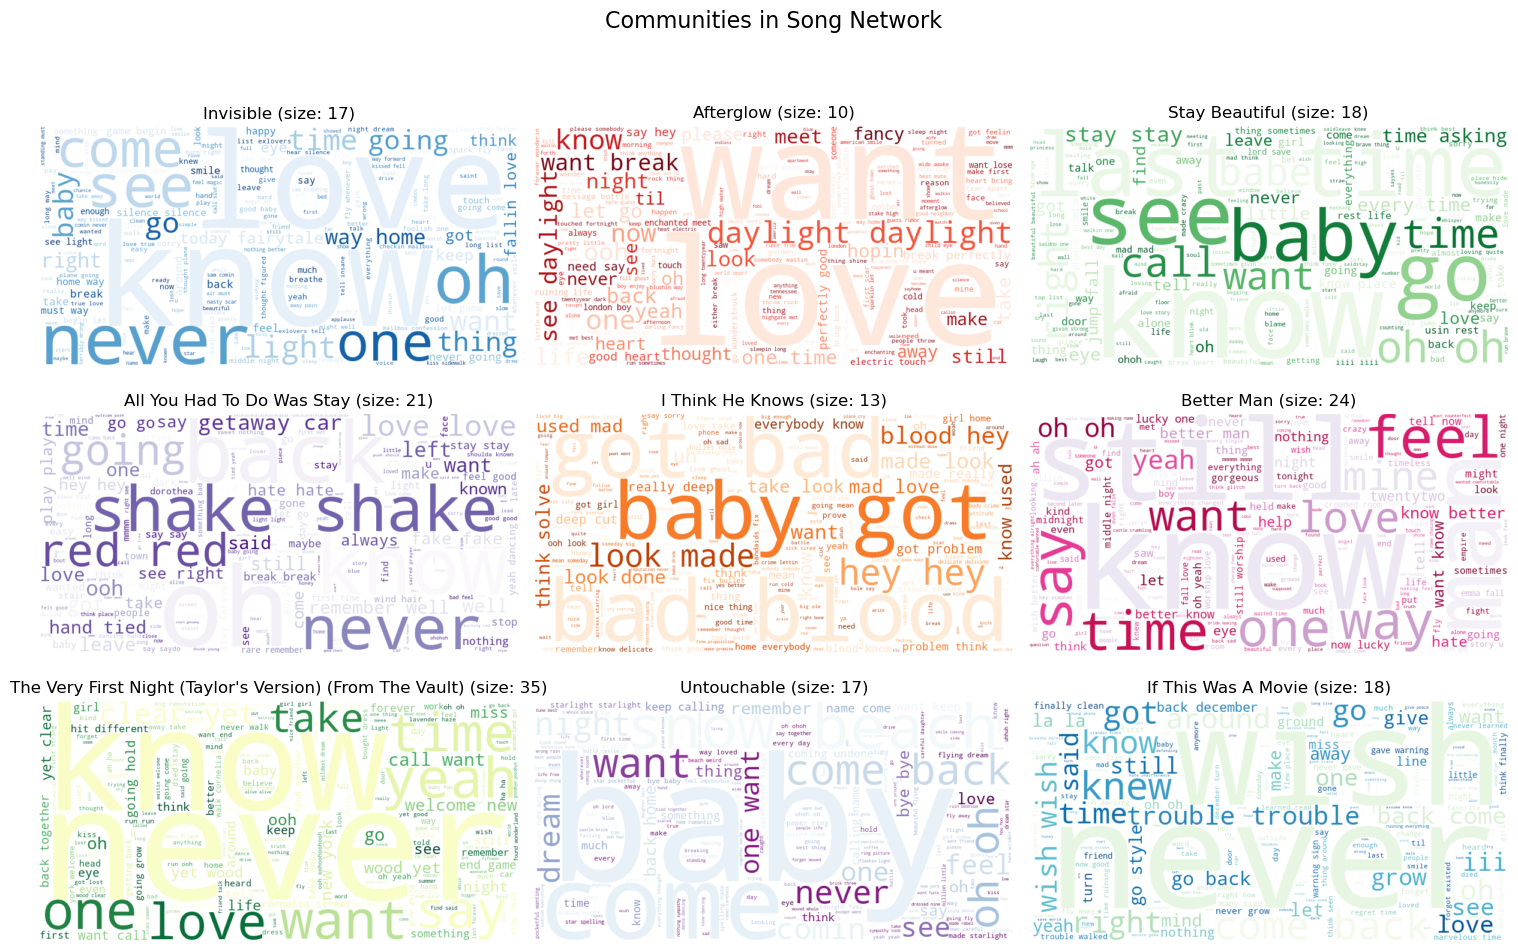

In [41]:
# Extract lyrics for each community
community_lyrics = {}
for comm_id, nodes in communities.items():
    community_lyrics[comm_id] = " ".join(
        updated_ts_data[updated_ts_data['track_name'].isin(nodes)]['cleaned_lyrics']
    )

# Define the number of rows and columns for the grid layout
num_communities = len(community_lyrics)
rows = (num_communities // 3) + (1 if num_communities % 3 else 0)
cols = min(3, num_communities)

# Create a colormap for different colors per community
# cmap = cm.get_cmap("tab10", num_communities)
colormap_names = ["Blues", "Reds", "Greens", "Purples", "Oranges", "PuRd",  "YlGn", "BuPu", "GnBu"]

# Generate the word clouds and organize them in a grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

for i, (comm_id, lyrics) in enumerate(community_lyrics.items()):
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap=colormap_names[i] ,
        random_state=42 ,
    ).generate(lyrics)
    
    # Plot the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(
        f"{community_names[comm_id]} (size: {len(communities[comm_id])})",
        color='black'  # Set the title color to match the community color
    )

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a global title
plt.suptitle("Communities in Song Network", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust spacing to fit the title
plt.show()


The word clouds reveal that several words, such as *love*, *never*, *want*, and *know*, are common across nearly all communities, highlighting central themes that recur throughout Taylor Swift's songwriting. These frequently shared words suggest that her music often explores themes of love and relationship. However, some communities stand out as distinct from the others,. These differences may be driven by individual songs within a community where certain words are repeated frequently, making those terms disproportionately prominent. This could reflect specific lyrical or thematic elements unique to those songs, distinguishing them from the broader trends seen across the rest of the network.

In [42]:
# Function to compute word frequencies for each community
def compute_word_frequencies(community_lyrics, communities):
    community_word_data = []
    for comm_id, nodes in communities.items():
        # Tokenize lyrics for each song in the community
        community_songs = updated_ts_data[updated_ts_data['track_name'].isin(nodes)]['cleaned_lyrics']
        word_in_songs = Counter()
        total_word_counts = Counter()

        for song in community_songs:
            if isinstance(song, str):  # Ensure song is valid text
                words = set(song.split())  # Use set to avoid double-counting a word in the same song
                total_word_counts.update(song.split())
                word_in_songs.update(words)  # Count word appearances across songs

        # Most common words by total count
        most_common_total = total_word_counts.most_common(5)

        # Most common words by the number of songs they appear in
        most_common_unique = word_in_songs.most_common(5)

        # Append data for the community
        community_word_data.append({
            "Community": f"{comm_id}: {community_names[comm_id]}",
            "Most Common Words (Total Number)": most_common_total,
            "Top Words by Song Presence": most_common_unique,
            "Size": len(communities[comm_id])
        })

    return community_word_data

# Compute word frequencies for all communities
community_word_data = compute_word_frequencies(community_lyrics, communities)

# Convert to a DataFrame for visualization
df = pd.DataFrame(community_word_data)

# Extract the numeric prefix from the "Community" column and sort by it
df['Community Index'] = df['Community'].str.extract(r'^(\d+):', expand=False).astype(int)
df = df.sort_values(by='Community Index').drop(columns=['Community Index'])

# Reset the index after sorting
df = df.reset_index(drop=True)

pd.set_option('max_colwidth', 200)
pd.set_option('display.max_columns', None)  


display(df)


Community  \
0                                                 0: Invisible   
1                                                 1: Afterglow   
2                                            2: Stay Beautiful   
3                                3: All You Had To Do Was Stay   
4                                          4: I Think He Knows   
5                                                5: Better Man   
6  6: The Very First Night (Taylor's Version) (From The Vault)   
7                                               7: Untouchable   
8                                       8: If This Was A Movie   

                                      Most Common Words (Total Number)  \
0         [(love, 82), (never, 62), (know, 57), (way, 53), (like, 47)]   
1     [(want, 64), (love, 56), (daylight, 40), (would, 28), (one, 27)]   
2          [(time, 106), (know, 80), (oh, 68), (baby, 51), (last, 44)]   
3            [(oh, 76), (love, 73), (shake, 70), (like, 66), (go, 51)]   
4          [(got, 142), (hey, 116), (know, 84), (look, 84), (bad, 74)]   
5         [(know, 124), (like, 101), (would, 96), (man, 57), (oh, 56)]   
6  [(want, 120), (never, 110), (would, 110), (like, 108), (know, 100)]   
7          [(like, 103), (oh, 84), (come, 80), (want, 62), (baby, 49)]   
8         [(would, 110), (wish, 88), (never, 86), (back, 72), (i, 72)]   

                                        Top Words by Song Presence  Size  
0      [(know, 14), (love, 13), (oh, 13), (like, 13), (never, 12)]    17  
1         [(love, 9), (want, 8), (like, 8), (back, 7), (would, 6)]    10  
2         [(know, 13), (oh, 13), (you, 13), (time, 12), (got, 11)]    18  
3        [(oh, 17), (like, 15), (could, 14), (know, 13), (go, 13)]    21  
4      [(like, 12), (know, 10), (got, 10), (thing, 9), (think, 9)]    13  
5     [(like, 21), (know, 20), (love, 16), (way, 14), (would, 14)]    24  
6    [(know, 26), (like, 25), (would, 23), (never, 22), (say, 21)]    35  
7       [(like, 16), (oh, 13), (would, 12), (back, 11), (you, 11)]    17  
8  [(would, 14), (know, 14), (never, 13), (could, 11), (like, 11)]    18

This table highlights patterns within the song network communities. Larger communities, like **The Very First Night (Taylor's Version) (From The Vault)**(35 songs), show strong cohesion with shared words such as *know* and *like*, reflecting thematic consistency. Smaller communities, like **Afterglow** (10 songs), display distinct common words such as *want* and *love*, but with less overlap, suggesting more varied or niche themes.

The balance between shared themes and individuality is evident, as communities like **Invisible** emphasize universal words (*love* and *never*) while others, like **Stay Beautiful**, focus on specific terms (*time* and *baby*). Larger communities tend to have stronger thematic connections, while smaller ones showcase a mix of shared and unique lyrical patterns, highlighting the diversity of song topics and community structures

In [43]:
# Prepare the data for the table
community_metrics = []

for comm_id, nodes in communities.items():
    lyrics = updated_ts_data[updated_ts_data['track_name'].isin(nodes)]['cleaned_lyrics']
    
    # Calculate metrics
    num_songs = len(nodes)
    word_counts = [len(song.split()) for song in lyrics]
    num_words = sum(word_counts) / len(word_counts) if word_counts else 0
    unique_word_counts = [len(set(song.split())) for song in lyrics]
    num_unique = sum(unique_word_counts) / len(unique_word_counts) if unique_word_counts else 0
    percentage_unique = num_unique / num_words if num_words else 0
    average_length = sum(len(word) for song in lyrics for word in song.split()) / sum(word_counts) if word_counts else 0
    
    # Get the average degree in the community
    subgraph = gcc.subgraph(nodes)
    degrees = [degree for _, degree in subgraph.degree()]
    average_degree = sum(degrees) / len(degrees) if degrees else 0
    
    # Find the most common words
    all_words = Counter(word for song in lyrics for word in song.split())
    common_words = [f"{word} ({count})" for word, count in all_words.most_common(5)]
    
    # Append metrics for this community
    community_metrics.append({
        "Community": f"{comm_id}: {community_names[comm_id]}",
        "num_songs": num_songs,
        "num_words": round(num_words, 2),
        "num_unique": round(num_unique, 2),
        "percentage_unique": round(percentage_unique, 2),
        "average_length": round(average_length, 2),
        "average_degree": round(average_degree, 2),
        "common_words": ", ".join(common_words)
    })

# Create a DataFrame for the table
community_metrics_df = pd.DataFrame(community_metrics)

display(community_metrics_df)


Community  num_songs  \
0                                                 0: Invisible         17   
1                                                 1: Afterglow         10   
2                                            2: Stay Beautiful         18   
3                                3: All You Had To Do Was Stay         21   
4                                          4: I Think He Knows         13   
5                                                5: Better Man         24   
6  6: The Very First Night (Taylor's Version) (From The Vault)         35   
7                                               7: Untouchable         17   
8                                       8: If This Was A Movie         18   

   num_words  num_unique  percentage_unique  average_length  average_degree  \
0     171.29       81.12               0.47            4.80            3.65   
1     177.40       82.40               0.46            4.95            2.60   
2     160.72       75.33               0.47            4.55            2.89   
3     197.90       96.00               0.49            4.73            2.48   
4     231.54       84.08               0.36            4.43            3.69   
5     165.46       82.17               0.50            4.88            3.67   
6     186.91       88.77               0.47            4.76            3.43   
7     186.88       83.71               0.45            4.84            2.71   
8     188.28       87.22               0.46            4.77            3.00   

                                                   common_words  
0         love (82), never (62), know (57), way (53), like (47)  
1     want (64), love (56), daylight (40), would (28), one (27)  
2          time (106), know (80), oh (68), baby (51), last (44)  
3            oh (76), love (73), shake (70), like (66), go (51)  
4          got (142), hey (116), know (84), look (84), bad (74)  
5         know (124), like (101), would (96), man (57), oh (56)  
6  want (120), never (110), would (110), like (108), know (100)  
7          like (103), oh (84), come (80), want (62), baby (49)  
8         would (110), wish (88), never (86), back (72), i (72)

This table provides a detailed overview of the characteristics of the song communities. It shows the number of songs per community, the average number of words and unique words, the percentage of unique words, and the average song length and degree. Larger communities, such as **The Very First Night (Taylor's Version) (From The Vault)**, tend to have higher connectivity (average degree) and a balance of shared and unique words, reflecting thematic cohesion. Smaller communities, like **Afterglow**, have fewer songs but stil its metrics are comprable to the ones of bigger communities. 

<a id='album-louvain'></a>
### Louvain communities vs album communities

For this comparison we will keep into account just the albumn and the songs of which we have critics reviews

In [44]:
# Extract the albums of which we have metacritics from the folder album_reviews
album_metacritics = os.listdir("./data/album_reviews")
album_metacritics = [x.split(".")[0] for x in album_metacritics]

#remove _ coming from the file name
album_metacritics = [x.replace("_", " ") for x in album_metacritics]

#change the names of the albums in the metractics files so that they are the same as in the dataset
changed_albums = album_metacritics.copy()
for album in album_metacritics:
    if "THE TORTURED" in album:
        #change to lower case from the second letter for each word
        words = album.split(" ")
        new = ""
        for w in words:
            #keep the first letter and change the rest to lower case
            new += w[0] + w[1:].lower() + " "
        #remove the last space
        new = new[:-1]
        #replace the album name
        changed_albums[changed_albums.index(album)] = new

print(f'Number of album keeped: {len(changed_albums)}')

Number of album keeped: 16


In [45]:
changed_albums

['1989',
 "1989 (Taylor's Version)",
 'evermore',
 'Fearless',
 "Fearless (Taylor's Version)",
 'folklore',
 'Lover',
 'Midnights',
 'Red',
 "Red (Taylor's Version)",
 'reputation',
 'Speak Now',
 "Speak Now (Taylor's Version)",
 'Taylor Swift',
 'The Tortured Poets Department',
 'The Tortured Poets Department: The Anthology']

Keep just the song belonging to one of the metacritics albums

In [46]:
def belongs_to_changed_albums(albums):
    if isinstance(albums, list):  
        return any(album in changed_albums for album in albums)
    elif isinstance(albums, str): 
        return albums in changed_albums
    return False  

# Apply the filter to create a sub-dataframe
filtered_df = updated_ts_data[updated_ts_data['album'].apply(belongs_to_changed_albums)]


def update_album_list(albums):
    if isinstance(albums, list):  # If it's a list, filter it
        return [album for album in albums if album in changed_albums]
    elif isinstance(albums, str):  # If it's a single string, check if it should be kept
        return [albums] if albums in changed_albums else []
    return []  # Return an empty list otherwise

filtered_df['album'] = filtered_df['album'].apply(update_album_list)

filtered_df = filtered_df.reset_index(drop=True)

print(filtered_df.shape)

(218, 28)


Let’s now partition the dataframe based on the album each song belongs to.

In [47]:
album_communities = defaultdict(list)

# Iterate through the dataframe
for _, row in filtered_df.iterrows():
    track_name = row['track_name']
    albums = row['album']  # Can be a list or a single string
    
    # If `albums` is a list, iterate through it; otherwise, treat it as a single album
    if isinstance(albums, list):
        for album in albums:
            album_communities[album].append(track_name)
    else:
        album_communities[albums].append(track_name)

# Convert defaultdict to a regular dictionary
album_communities = dict(album_communities)


In [48]:
sorted_album_communities = dict(sorted(album_communities.items(), key=lambda x: x[0]))

In [49]:
# For each community (album) extract the lyrics 
album_communities_lyrics = {}
for album_name, songs in album_communities.items():
    album_communities_lyrics[album_name] = " ".join(
        filtered_df[filtered_df['track_name'].isin(songs)]['cleaned_lyrics']
    )

In [50]:
# Sort the keys alphabetically and create a new dictionary
album_communities_lyrics_sorted = {
    key: album_communities_lyrics[key]
    for key in sorted(album_communities_lyrics.keys())
}

For each community, we compute and plot the word clouds. The albums, which serve as the keys of the dictionary, have been sorted to ensure that multiple versions of the same album appear consecutively. Additionally, the color palettes for the word clouds are chosen to match, so that different versions of the same album share the same color palette.

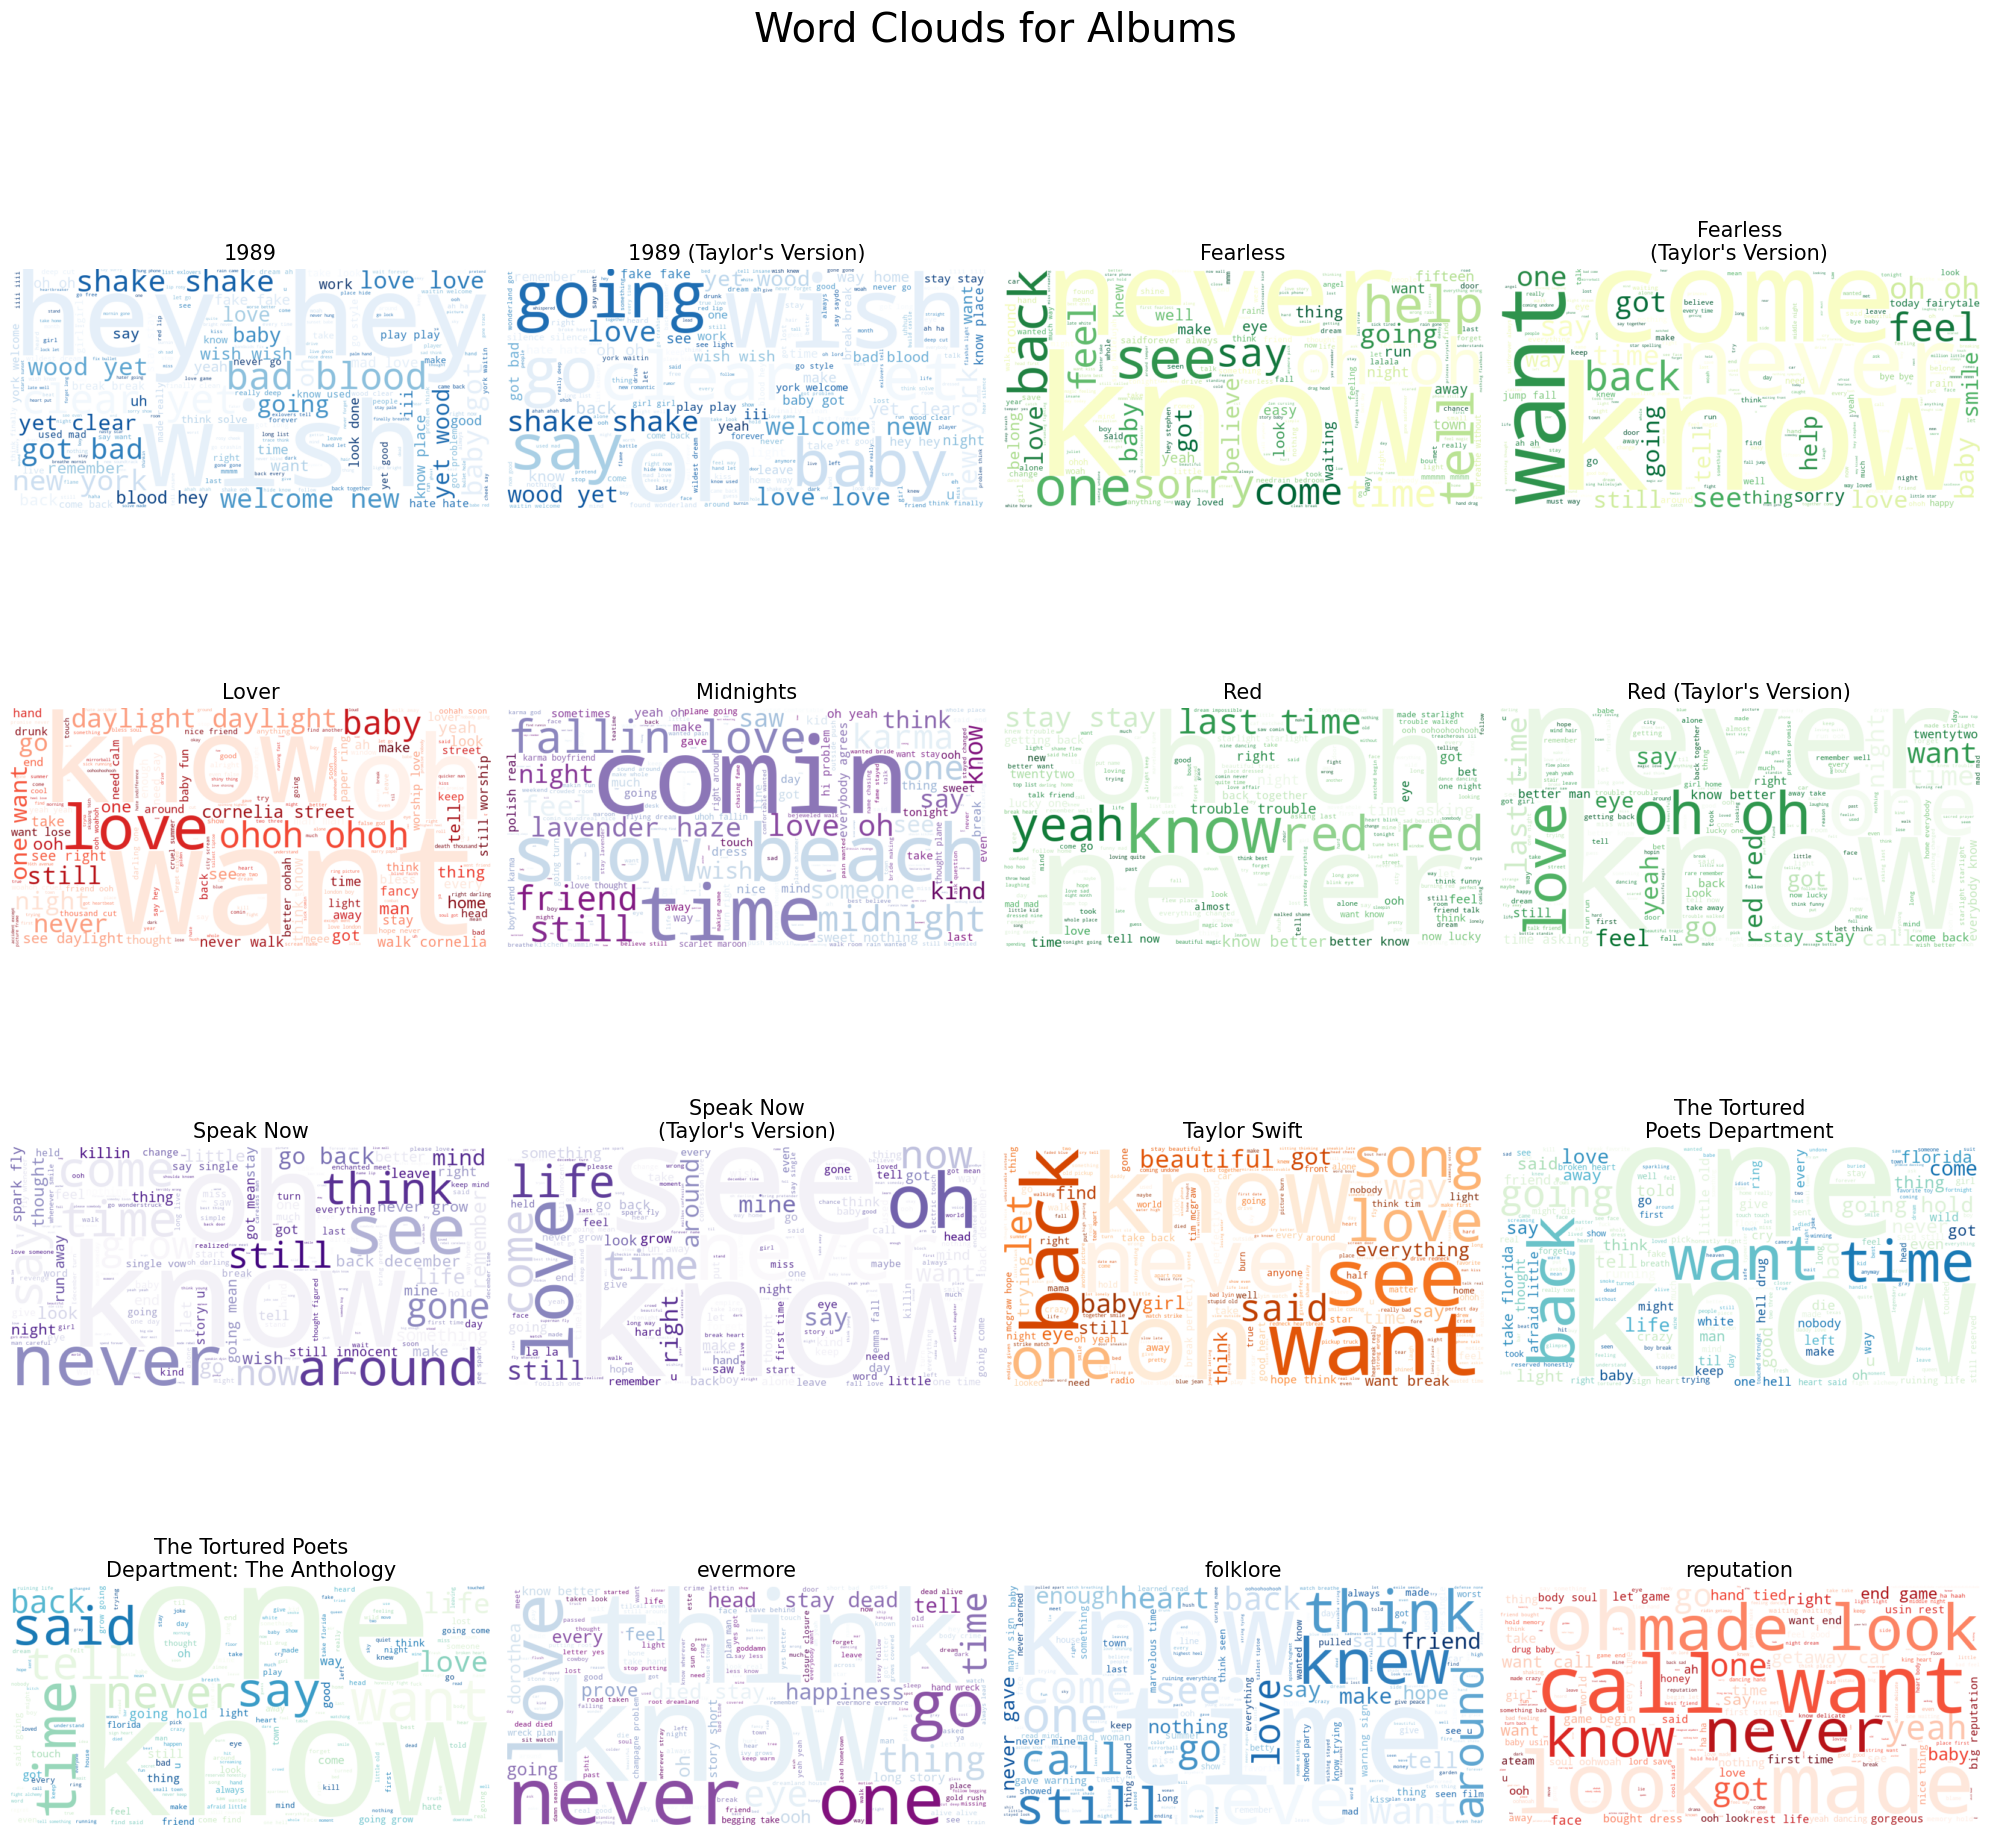

In [51]:
# Define a list of colormaps
colormap_names = ["Blues", "Blues", 
                  "YlGn", "YlGn",
                  "Reds", 
                  "BuPu",
                  "Greens", "Greens",
                  "Purples", "Purples", 
                  "Oranges", 
                  "GnBu", "GnBu",
                  "BuPu", 
                  "Blues", "Reds", 
                ]

# Define rows and columns for the grid
rows = 4
cols = 4

# Create the grid plot
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
axes = axes.flatten()

# Function to wrap album titles more elegantly
def wrap_title(title, max_length=25):
    if len(title) <= max_length:
        return title
    words = title.split()
    mid_point = len(words) // 2
    line_1 = " ".join(words[:mid_point])
    line_2 = " ".join(words[mid_point:])
    return f"{line_1}\n{line_2}"

# Plot each word cloud
for i, (album, lyrics) in enumerate(album_communities_lyrics_sorted.items()):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colormap_names[i],
        random_state=42
    ).generate(lyrics)
    
    # Plot the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    # Put in two lines if the title if it is too long
    max_length = 25
    formatted_title = wrap_title(album)
    axes[i].set_title(formatted_title, fontsize=15)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a global title
plt.suptitle("Word Clouds for Albums", fontsize=29)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust spacing to fit the title
plt.show()



As seen in the previous word clouds, the recurring words continue to focus on themes of love and relationships. However, certain albums, such as *Midnights* and *Reputation*, stand out by diverging more from these common themes.

In [52]:
# Calculate the number of songs in each album community
album_song_counts = {album: len(set(songs)) for album, songs in album_communities.items()}
album_song_counts_df = pd.DataFrame(list(album_song_counts.items()), columns=["Album", "Number of Songs"])

# Sort the DataFrame by the number of songs in descending order
album_song_counts_df = album_song_counts_df.sort_values(by="Number of Songs", ascending=False).reset_index(drop=True)

# Display the DataFrame
display(album_song_counts_df)


Album  Number of Songs
0   The Tortured Poets Department: The Anthology               31
1                         Red (Taylor's Version)               29
2                    Fearless (Taylor's Version)               25
3                   Speak Now (Taylor's Version)               22
4                        1989 (Taylor's Version)               21
5                                          Lover               18
6                                       folklore               16
7                  The Tortured Poets Department               16
8                                            Red               16
9                                       evermore               15
10                                    reputation               15
11                                  Taylor Swift               14
12                                     Speak Now               14
13                                     Midnights               13
14                                          1989               13
15                                      Fearless               13

In [53]:
# Function to compute word frequencies for album-based communities
def compute_word_frequencies_albums(album_lyrics, album_communities):
    album_word_data = []
    for album_name, songs in album_communities.items():
        # Ensure `songs` is always treated as a list
        if isinstance(songs, str):
            flat_song_list = [songs]  # If it's a single string, wrap it in a list
        else:
            flat_song_list = list(songs)  # Otherwise, convert it to a list (if it's not already)

        # Tokenize lyrics for each song in the album
        album_songs = filtered_df[filtered_df['track_name'].isin(flat_song_list)]['cleaned_lyrics']
        word_in_songs = Counter()
        total_word_counts = Counter()

        for song in album_songs:
            if isinstance(song, str):  # Ensure song is valid text
                words = set(song.split())  # Use set to avoid double-counting a word in the same song
                total_word_counts.update(song.split())
                word_in_songs.update(words)  # Count word appearances across songs

        # Most common words by total count
        most_common_total = total_word_counts.most_common(5)

        # Most common words by the number of songs they appear in
        most_common_unique = word_in_songs.most_common(5)

        # Append data for the album
        album_word_data.append({
            "Album": album_name,
            "Most Common Words (Total Number)": most_common_total,
            "Top Words by Song Presence": most_common_unique,
            "Size": len(flat_song_list)
        })

    return album_word_data

# Compute word frequencies for all album-based communities
album_word_data = compute_word_frequencies_albums(album_communities_lyrics_sorted, sorted_album_communities)

# Convert to a DataFrame for visualization
df_album = pd.DataFrame(album_word_data)

# Sort by Album names alphabetically
df_album = df_album.sort_values(by='Album').reset_index(drop=True)

# Set pandas options for better display
pd.set_option('max_colwidth', 200)
pd.set_option('display.max_columns', None)

# Display the DataFrame
display(df_album)

Album  \
0                                           1989   
1                        1989 (Taylor's Version)   
2                                       Fearless   
3                    Fearless (Taylor's Version)   
4                                          Lover   
5                                      Midnights   
6                                            Red   
7                         Red (Taylor's Version)   
8                                      Speak Now   
9                   Speak Now (Taylor's Version)   
10                                  Taylor Swift   
11                 The Tortured Poets Department   
12  The Tortured Poets Department: The Anthology   
13                                      evermore   
14                                      folklore   
15                                    reputation   

                                   Most Common Words (Total Number)  \
0          [(i, 100), (love, 88), (hey, 83), (wish, 81), (got, 70)]   
1        [(love, 108), (i, 101), (oh, 90), (wish, 81), (shake, 70)]   
2       [(know, 61), (oh, 50), (cannot, 29), (never, 26), (no, 26)]   
3         [(know, 89), (oh, 71), (come, 57), (like, 51), (you, 45)]   
4     [(want, 88), (would, 71), (like, 67), (love, 48), (know, 48)]   
5      [(like, 52), (karma, 28), (love, 25), (comin, 25), (oh, 23)]   
6       [(like, 80), (know, 77), (time, 69), (oh, 64), (never, 57)]   
7      [(know, 142), (like, 128), (time, 104), (oh, 92), (one, 73)]   
8    [(like, 47), (know, 37), (would, 36), (never, 35), (back, 32)]   
9     [(would, 76), (like, 65), (know, 62), (see, 57), (never, 53)]   
10     [(oh, 45), (know, 37), (want, 33), (would, 28), (think, 26)]   
11      [(going, 40), (you, 38), (one, 37), (like, 36), (know, 35)]   
12     [(like, 79), (going, 77), (one, 63), (know, 59), (said, 54)]   
13  [(know, 49), (like, 48), (could, 31), (would, 30), (think, 27)]   
14   [(would, 50), (never, 46), (time, 45), (know, 45), (like, 41)]   
15     [(want, 88), (made, 53), (like, 52), (look, 48), (call, 47)]   

                                       Top Words by Song Presence  Size  
0      [(could, 11), (know, 10), (like, 10), (back, 9), (say, 8)]    13  
1   [(back, 15), (know, 14), (like, 14), (could, 13), (love, 12)]    21  
2         [(say, 11), (know, 11), (oh, 10), (never, 9), (got, 9)]    13  
3        [(know, 19), (say, 18), (like, 17), (oh, 17), (you, 16)]    25  
4       [(like, 15), (want, 12), (you, 12), (know, 11), (go, 10)]    18  
5         [(like, 9), (time, 9), (love, 7), (going, 7), (one, 6)]    13  
6      [(like, 14), (time, 14), (know, 12), (oh, 10), (would, 9)]    16  
7   [(like, 25), (know, 24), (time, 23), (would, 18), (love, 18)]    29  
8   [(like, 13), (would, 11), (you, 11), (know, 11), (never, 10)]    14  
9   [(like, 21), (know, 19), (would, 16), (never, 16), (you, 14)]    22  
10           [(oh, 11), (know, 10), (one, 8), (way, 8), (see, 8)]    14  
11    [(one, 13), (like, 13), (say, 11), (would, 10), (know, 10)]    16  
12    [(like, 26), (one, 23), (know, 21), (would, 19), (say, 16)]    31  
13     [(would, 12), (know, 12), (like, 11), (go, 9), (could, 8)]    15  
14   [(would, 12), (know, 11), (like, 11), (time, 11), (one, 10)]    16  
15           [(oh, 13), (like, 12), (me, 10), (you, 9), (one, 9)]    15

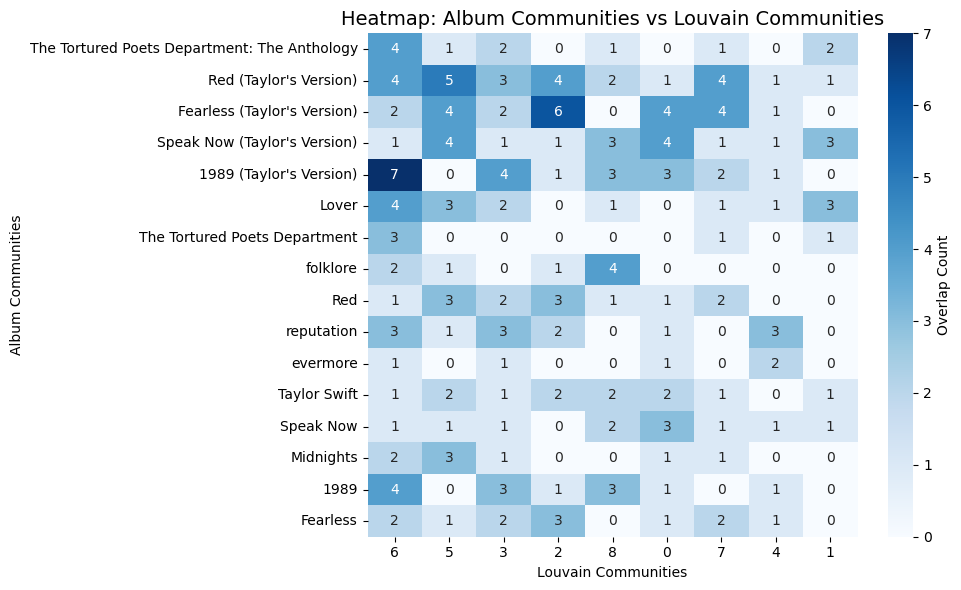

In [54]:
# Example: Compute sizes of album communities
album_sizes = {album: len(songs) for album, songs in album_communities.items()}
top_albums = sorted(album_sizes, key=album_sizes.get, reverse=True)# [:5]  # Top 5 albums

# Example: Compute sizes of Louvain communities
louvain_sizes = {community: len(nodes) for community, nodes in communities.items()}
top_louvain = sorted(louvain_sizes, key=louvain_sizes.get, reverse=True) # [:5]  # Top 5 Louvain communities

# Initialize confusion matrix
confusion_matrix = pd.DataFrame(0, index=top_albums, columns=top_louvain)

# Populate the confusion matrix
for album in top_albums:
    for louvain_comm in top_louvain:
        # Count overlap between album and Louvain communities
        album_songs = set(album_communities[album])
        louvain_songs = set(communities[louvain_comm])
        overlap = len(album_songs.intersection(louvain_songs))
        confusion_matrix.at[album, louvain_comm] = overlap

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar_kws={'label': 'Overlap Count'}
)
plt.title("Heatmap: Album Communities vs Louvain Communities", fontsize=14)
plt.xlabel("Louvain Communities")
plt.ylabel("Album Communities")
plt.tight_layout()
plt.show()

This heatmap represents the intersection between Louvain communities and album communities, showing the overlap in terms of the number of songs shared between each pair. Some elements of the album communities do not belong to the larger Louvain communities, and thus are not included in this map. This explains why the sum of counts in some rows does not match the total size of the corresponding album communities.

The diagonal pattern in the heatmap suggests that certain album communities, such as *"1989 (Taylor's Version)"*, strongly overlap with specific Louvain communities, as seen in the highest intersection count of 7. This indicates that songs from this album are tightly grouped into one Louvain community. Similarly, albums like *"Red (Taylor's Version)"* and *"Fearless (Taylor's Version)"* show significant overlaps with multiple Louvain communities, reflecting shared lyrical themes both within and across albums.

In contrast, smaller intersections, such as *"The Tortured Poets Department"* or *"Midnights"*, suggest that their songs are distributed across different Louvain communities, highlighting a broader thematic spread or fewer strong connections within the larger modularity-based communities. 

<a id='centrality'></a>
### Centrality analysis

It is important to identify the most central songs, that is why we calculate the centrality measures by analyzing degree, betweenness, closeness and eigenvector centrality. Thanks to this, we can gain insights into the structure and influence of Taylor Swift's songs.

In [55]:
# load the pickle network
with open('song_network.pkl', 'rb') as f:
    net = pickle.load(f)

In [56]:
# calculate centrality measures
degree = dict(net.degree())
betweenness = nx.betweenness_centrality(net)
closeness = nx.closeness_centrality(net)
eigenvector = nx.eigenvector_centrality(net)

# sort the nodes by centrality measures
degree_sorted = sorted(degree, key=degree.get, reverse=True)
betweenness_sorted = sorted(betweenness, key=betweenness.get, reverse=True)
closeness_sorted = sorted(closeness, key=closeness.get, reverse=True)
eigenvector_sorted = sorted(eigenvector, key=eigenvector.get, reverse=True)

# print the top 5 nodes for each centrality measure with their centrality scores
print("Degree")
for node in degree_sorted[:5]:
    print(f"{node}: {degree[node]}")
print('---------------------------------')
print("Betweenness")
for node in betweenness_sorted[:5]:
    print(f"{node}: {betweenness[node]}")
print('---------------------------------')
print("Closeness")
for node in closeness_sorted[:5]:
    print(f"{node}: {closeness[node]}")
print('---------------------------------')
print("Eigenvector")
for node in eigenvector_sorted[:5]:
    print(f"{node}: {eigenvector[node]}")

Degree
All You Had To Do Was Stay: 27
The Very First Night (Taylor's Version) (From The Vault): 26
22: 26
Better Man: 26
Invisible: 25
---------------------------------
Betweenness
22: 0.016665606839756722
All You Had To Do Was Stay: 0.01545921029111301
If This Was A Movie: 0.014379143094615748
Better Man: 0.013137777296740646
Haunted: 0.011278523452508267
---------------------------------
Closeness
The Very First Night (Taylor's Version) (From The Vault): 0.16066831428277212
Don't You (Taylor's Version) (From The Vault): 0.13898538737248414
Run (feat. Ed Sheeran) (Taylor's Version) (From The Vault): 0.13538548310121915
I Can See You (Taylor's Version) (From The Vault): 0.13283632666892578
Nothing New (feat. Phoebe Bridgers) (Taylor's Version) (From The Vault): 0.12939491064491065
---------------------------------
Eigenvector
The Very First Night (Taylor's Version) (From The Vault): 0.5116636459522789
Run (feat. Ed Sheeran) (Taylor's Version) (From The Vault): 0.4161548534942395
Foreve

To make the analysis easier, we create a new and smaller DataFrame with only the necessary information.

In [57]:
# Create a DataFrame for analysis
centrality_data = pd.DataFrame({
    'song_id': degree.keys(),
    'degree': degree.values(),
    'betweenness': betweenness.values(),
    'closeness': closeness.values(),
    'eigenvector': eigenvector.values()
})

# Add the number of streams to the DataFrame
streams = nx.get_node_attributes(net, 'spotify_streams')
streams_data = pd.DataFrame(streams.items(), columns=['song_id', 'streams'])

# Merge centrality measures with streams data
centrality_data = centrality_data.merge(streams_data, on='song_id')

# print how many rows and columns the DataFrame has
print(centrality_data.shape)
# Sum the streams if a node has a list with more than one value
centrality_data['streams'] = centrality_data['streams'].apply(lambda x: sum(x) if isinstance(x, list) else x)

# print the updated DataFrame
centrality_data.head()

(235, 6)


song_id  degree  betweenness  \
0  "Slut!" (Taylor's Version) (From The Vault)       3     0.000000   
1                             ...Ready For It?      10     0.000764   
2                       A Perfectly Good Heart       9     0.000000   
3                        A Place in this World       3     0.000000   
4                                    Afterglow      12     0.003023   

   closeness   eigenvector    streams  
0   0.082824  6.526134e-02  239579759  
1   0.080247  3.958429e-02  695895392  
2   0.000000  1.767125e-29   25204096  
3   0.006410  5.644276e-10   40680546  
4   0.092398  6.447317e-02  368409481

We want to study if there is some correlation between these centralities metrics and the number of streams. We visualize the correlation matrix through a heatmap to identify significant patterns and connections.

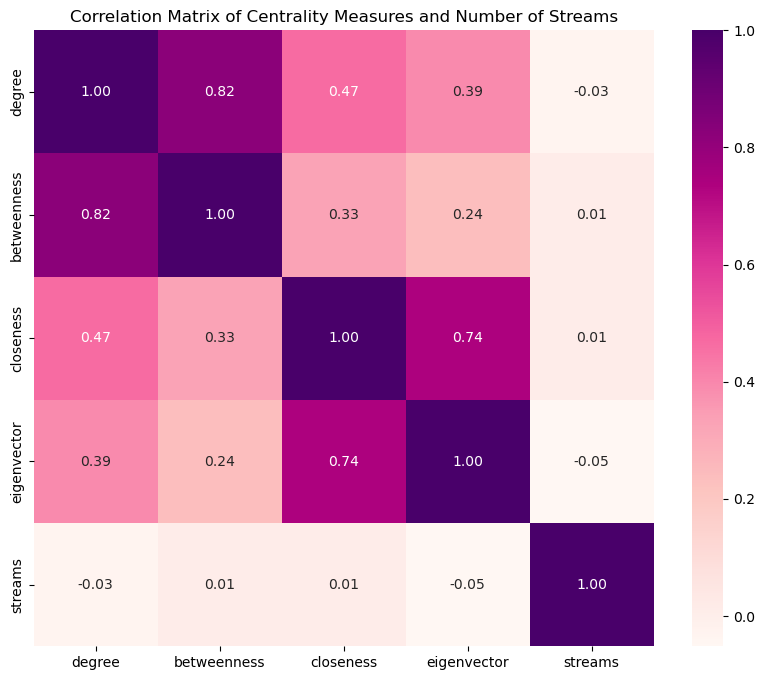

In [58]:
# calculate correlation between centrality measures
correlation = centrality_data.select_dtypes(include=[np.number]).corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='RdPu', fmt=".2f")
plt.title('Correlation Matrix of Centrality Measures and Number of Streams')
plt.show()

The correlation analysis of centrality measures and Spotify streams for Taylor Swift's songs reveals that there is no significant direct correlation between the centrality metrics and the number of streams. 

High correlations among certain centrality measures (such as degree and betweenness or closeness and eigenvector) indicate that well-connected songs often serve as bridges and are close to other songs in the network. However, these structural properties do not indicate higher stream counts. We can conclude that these measures do not play a crucial role in determining the popularity of Taylor Swift's songs on Spotify and probably, other factors as lyrical content, marketing or fan engagement, influence more.

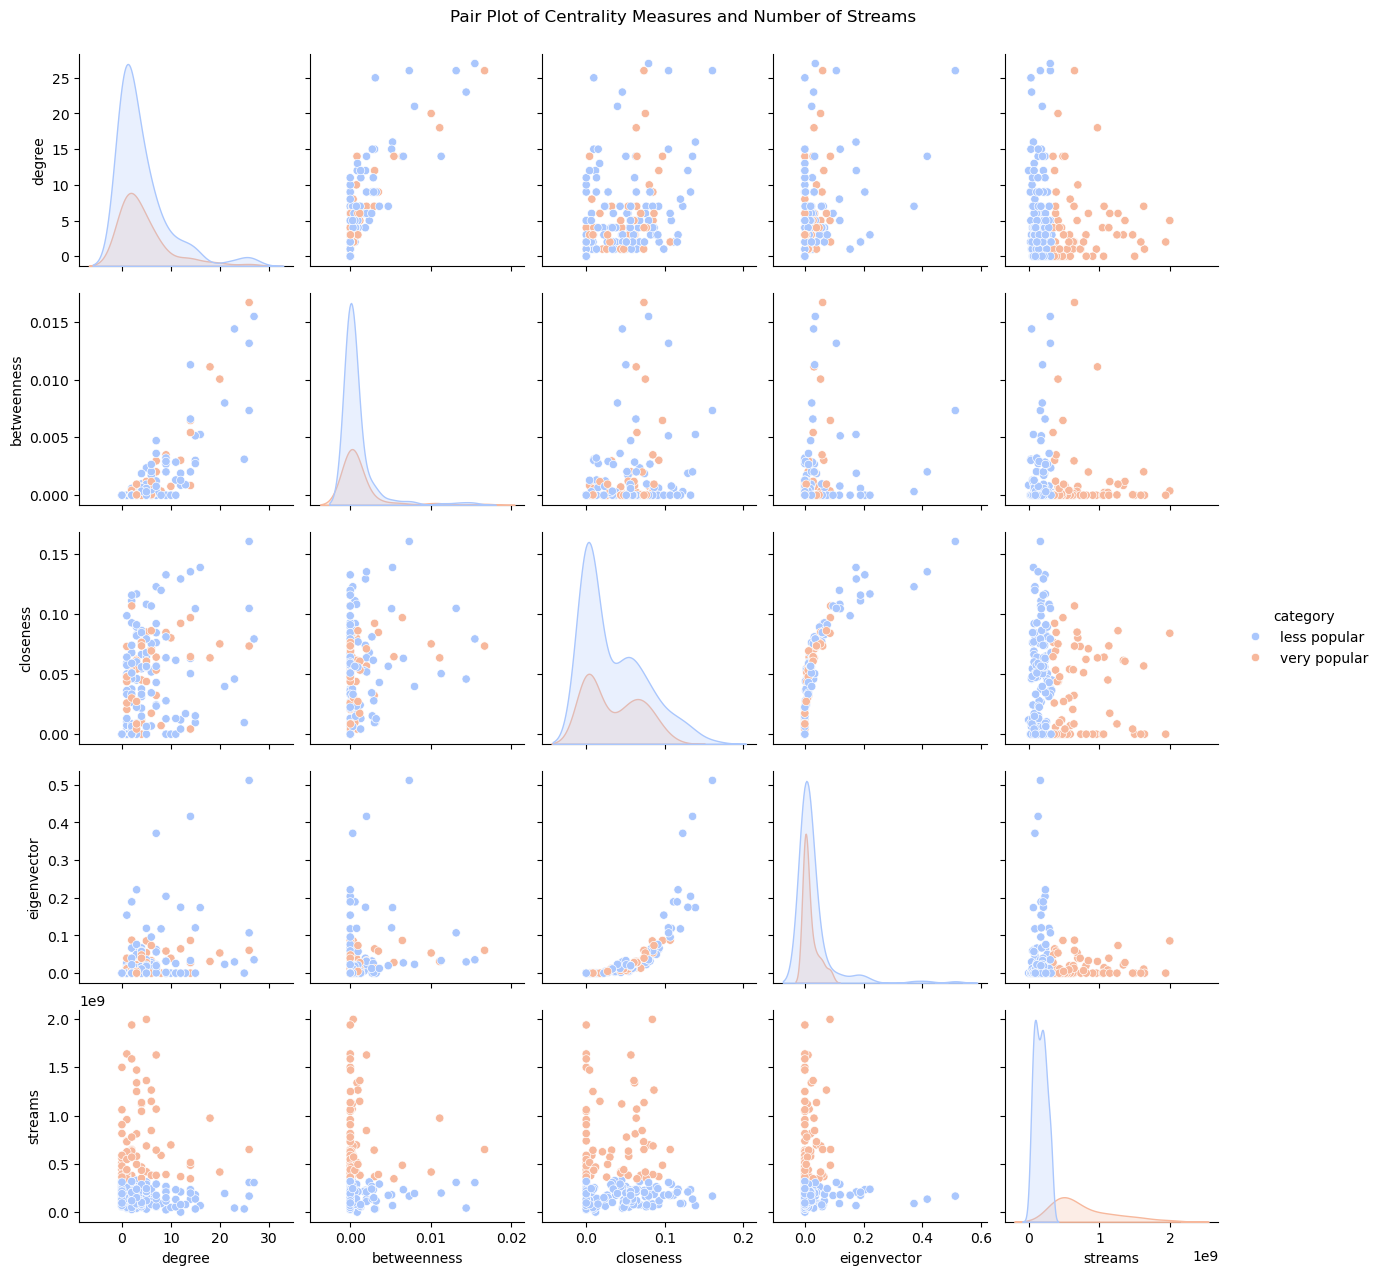

In [59]:
# Assuming we have a categorical variable to use for hue, e.g., 'category'
# You can create a dummy categorical variable for demonstration
centrality_data['category'] = np.where(centrality_data['streams'] > centrality_data['streams'].mean(), 'very popular', 'less popular')

# Create a pair plot using the hue parameter
sns.pairplot(centrality_data[['degree', 'betweenness', 'closeness', 'eigenvector', 'streams', 'category']],
             hue='category', palette='coolwarm')
plt.suptitle('Pair Plot of Centrality Measures and Number of Streams', y=1.02)
plt.show()

First of all, the songs were categorized into *very popular* and *less popular* based on the mean number of Spotify streams to ensure a balanced distribution and use a robust measure of central tendency.

When analyzing the resulting pairplot, we can extract different conclusions:
- **Degreen centrality vs. streams:** there is a slight negative correlation, especially for the *very popular* ones and this indicates that songs with higher degree centrality are not nec3essarily the ones with the highest number of streams. Therefore, having more shared words does not directly correlate with popularity.

- **Betweeness centrality vs. streams:** the betweeness is low for most songs and doesn't have a clear pattern. For this reason, acting as a bridge between songs in terms of shared top words doesn't impact the number of streams.

- **Closeness centrality vs. streams:** there is a noticeable clustering of higher streams with higher closeness but it is not strong. Therefore, central songs might have a slight advantage in gaining streams.

- **Eigenvector centrality vs. streams:** there is a slight negative correlation between them indicating that songs that are connected to other popular songs don't necessary guarantee higher streams.

- **Streams distribution:** it can be seen that *very popular* songs are more spread out while *less popular* ones are clustered at the lower end of the stream spectrum. This results can be affected with the fact that for the re-released songs, we decided to sum the number of streams so that it could be why the *very popular* ones are not clustered. However, this could also highlight the disparity in popularity where a few songs dominate in streams.

Given that some of Taylor Swif's songs were re-released and their streams were summed, these songs likely appear more popular in the plots. However, we also plotted the same graphs without summing the number of streams of the re-released songs and just taking the higher number. Even though the results didn't change at all, it can be concluded that re-releasing songs with multiple versions, gave a slight better network positioning enhacing their visibility.

In conclusion, centrality measures alone do not show strong correlations with the number of streams. This suggests that other factors beyond network centrality play more significant roles in determining a song's popularity. However, we could observe that closeness centrality showed a slight advantage for popular songs indicating that being more central in terms of shared top words can help in gaining streams, but not as a sole factor.

<a id='sentiment'></a>
## Sentiment Analysis

In this section we analyze the sentiment of Taylor swift's songs lyrics. To do so, we will use the updated_ts_data dataframe, which is the result of the previously done preprocessing.

<a id='sentiment-evaluation'></a>
### LabMT Wordlist Sentiment Evaluation

In [60]:
# iterate through the data and sum the spotify streams of the songs if it's a list
for i,row in updated_ts_data.iterrows():
    if type(row['spotify_streams']) == list:
        updated_ts_data.at[i,'spotify_streams'] = sum(row['spotify_streams'])
    else:
        updated_ts_data.at[i,'spotify_streams'] = row['spotify_streams']

updated_ts_data['spotify_streams'] = updated_ts_data['spotify_streams'].astype(int)

First, we build a function that takes the LabMT wordlist as a parameter and it returns the dictionary with the words in the file and their correspondant sentiment score.

In [61]:
def sentiment_dictionary(LabMT = 'data/Data_Set_S1.txt'):
    """
    This function loads the LabMT wordlist and creates a dictionary of words and their happiness values.
    labMT: str, the path to the LabMT wordlist
    """
    #load the LabMT wordlist from Data_Set_S1.txt
    with open(LabMT, 'r') as f:
        lines = f.readlines()
    
    #remove the first foour lines 
    lines = lines[4:]

    #create a dictionary of words and their happiness values
    word_dict = defaultdict(float)
    for line in lines:
        line = line.split('\t')
        word = line[0]
        happiness = float(line[2])
        #print(word, happiness)
        word_dict[word] = happiness

    return word_dict

We then build a function to clean and transfrom the lyrics into tokens. Eventhough we already cleaned the lyrics, the preprocessing was specific to the previous task and the result was saved them in a new column (clean_lyrics).

In [62]:
def lyrics_to_tokens(lyrics):
    """
    This function takes a string of lyrics and returns a list of tokens.
    lyrics: str, a string of lyrics    
    """
    #convert to lower case
    lyrics = lyrics.lower()
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    #remove punctuation
    lyrics = lyrics.translate(str.maketrans('', '', string.punctuation))
    #tokenize the lyrics
    tokens = word_tokenize(lyrics)

    tokens = [word for word in tokens if word not in stop_words]
    #lemmatize the tokens
    #lemmatizer = WordNetLemmatizer() We do not lemmatize the words because the LabMT wordlist is not lemmatized
    return tokens

Here we build a function that calculates the sentiment of a song based on the word dictionary previously obtained. To calculate the sentiment score we use the weighted sum, so that the words contribute to the sentiment score based on the frequency in which they appear. Furthermore, this function also returns the words that are present in the LabMT wordlist with the scores and their frequency in the song.

In [63]:
#function to calculate sentiment given a list of tokens based on the LabMT wordlist dictionary
def sentiment_with_words(lyrics, word_dict):
    """
    This function calculates the sentiment of a list of tokens based on the LabMT wordlist dictionary. 
    It also returns the words that are in the LabMT wordlist, their frequency and scores
    tokens: list, a list of tokens
    word_dict: dict, a dictionary of words and their happiness values
    """
    tokens = lyrics_to_tokens(lyrics)
    #calculate the frequency of each word in the tokens list
    freq = defaultdict(int)
    for token in tokens:
        freq[token] += 1

    word_list = []
    #calculate the happiness score of the tokens list
    score = 0
    count = 0
    for word in freq:
        if word in word_dict:
            word_list.append((word, freq[word], word_dict[word]))
            score += freq[word] * word_dict[word]
            count += freq[word]
            sentiment = score / count
    return sentiment, word_list

Next we build the function that iterates through the dataframe and obtains the sentiment score for each song (using the previously defined function) and also returns the three happiest and saddest words in each song. Furthermore, it also categorises the words (happy, neutral, sad) based on the input thresholds. The result of the categorization is returned as the percentage of words in each category.

In [64]:
def calculate_sentiments_with_details(df, low_threshold, high_threshold):
    """
    This function calculates the sentiment of each track in the dataframe and returns the happiest and saddest words.
    df: pandas dataframe, a dataframe with a column of track lyrics
    low_threshold, high_threshold: float, the thresholds for the sentiment categories
    """
    # add the three happiest words and three saddest words to the sentiments_dict with their scores and frequencies
    word_dict = sentiment_dictionary()
    sentiments_dict = defaultdict(dict)
    for index, row in df.iterrows():
        lyrics = row['track_lyrics']
        if type(lyrics) == list:
            for lyric in lyrics:
                sentiment_score, word_list = sentiment_with_words(lyric, word_dict)
                sentiments_dict[row['track_name']]['sentiment'] = round(sentiment_score,2)

                #obtain the percentage of sentiment category
                happy_percentage = round((len([word for word in word_list if word[2] > high_threshold]) / len(word_list))*100,2)
                sentiments_dict[row['track_name']]['happy_percentage'] = happy_percentage
                sad_percentage = round((len([word for word in word_list if word[2] < low_threshold]) / len(word_list))*100,2)
                sentiments_dict[row['track_name']]['sad_percentage'] = sad_percentage
                neutral_percentage = 100 - happy_percentage - sad_percentage
                sentiments_dict[row['track_name']]['neutral_percentage'] = neutral_percentage

                #order the word_list by score
                word_list = sorted(word_list, key=lambda x: x[2])
                sentiments_dict[row['track_name']]['saddest words'] = word_list[:3]
                sentiments_dict[row['track_name']]['happiest words'] = word_list[-3:]
        else:
            sentiment_score, word_list = sentiment_with_words(lyrics, word_dict)
            sentiments_dict[row['track_name']]['sentiment'] = round(sentiment_score,2)

            #obtain the percentage of sentiment category
            happy_percentage = round((len([word for word in word_list if word[2] > high_threshold]) / len(word_list))*100,2)
            sentiments_dict[row['track_name']]['happy_percentage'] = happy_percentage
            sad_percentage = round((len([word for word in word_list if word[2] < low_threshold]) / len(word_list))*100,2)
            sentiments_dict[row['track_name']]['sad_percentage'] = sad_percentage
            neutral_percentage = 100 - happy_percentage - sad_percentage
            sentiments_dict[row['track_name']]['neutral_percentage'] = neutral_percentage
            

            #order the word_list by score
            word_list = sorted(word_list, key=lambda x: x[2])
            sentiments_dict[row['track_name']]['saddest words'] = word_list[:3]
            sentiments_dict[row['track_name']]['happiest words'] = word_list[-3:]

    return sentiments_dict

In the next cell we compute the threholds to create the word categories. This is done based on the whole word list.

In [65]:
#obtain the dictionary with the words and their happiness values
word_dict = sentiment_dictionary()

sentiment_values = np.array(list(word_dict.values()))

#calculate the thresholds for three categories: sad, neutral and happy
low_threshold = np.percentile(sentiment_values, 33)  
high_threshold = np.percentile(sentiment_values, 66)

print(f'The words with a sentiment score below {low_threshold} are considered sad')
print(f'The words with a sentiment score between {low_threshold} and {high_threshold} are considered neutral')
print(f'The words with a sentiment score above {high_threshold} are considered happy')

The words with a sentiment score below 5.08 are considered sad
The words with a sentiment score between 5.08 and 5.78 are considered neutral
The words with a sentiment score above 5.78 are considered happy


In [66]:
# nltk.download('punkt_tab')

In [67]:
song_sentiments_with_details = calculate_sentiments_with_details(updated_ts_data, low_threshold, high_threshold)

In [68]:
#calculate the stats of all the sentiments
sentiments = [value['sentiment'] for value in song_sentiments_with_details.values()]
sentiments = np.array(sentiments)

print('Mean sentiment:', np.mean(sentiments))
print('Median sentiment:', np.median(sentiments))
print('Standard deviation sentiment:', np.std(sentiments))
print('Minimum sentiment:', np.min(sentiments))
print('Maximum sentiment:', np.max(sentiments))

Mean sentiment: 5.51136170212766
Median sentiment: 5.53
Standard deviation sentiment: 0.24309497535718683
Minimum sentiment: 4.61
Maximum sentiment: 6.24


<a id='sentiment-distribution'></a>
### Sentiment Distribution Visualization

We can see that the songs tend to be neutral but with a high value, which leads us to think that they are happier songs. This can also be confirmed by looking into the sentiment distrbution plotted below.

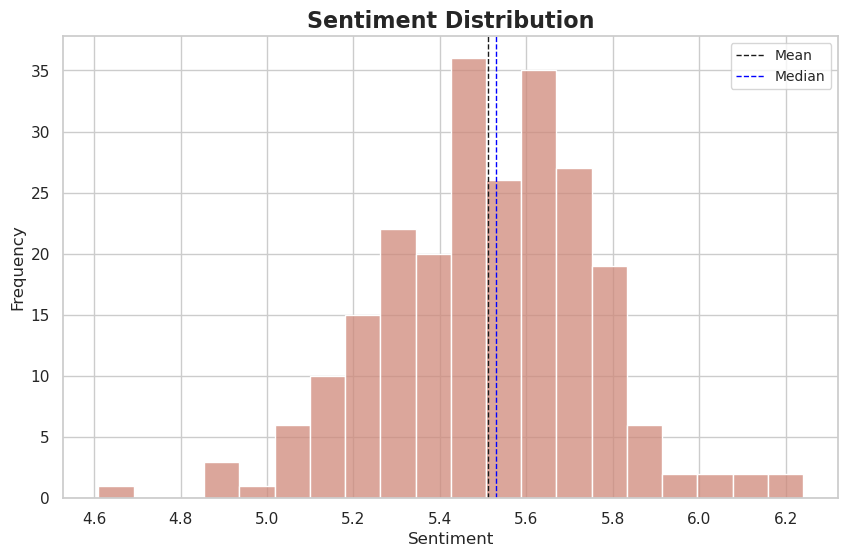

In [69]:
#plot the distribution of the sentiments
# Set the Seaborn theme 
sns.set_theme(style="whitegrid", palette="pastel")

plt.figure(figsize=(10, 6))

# Create the histogram
sns.histplot(sentiments, bins=20, color='#cf897a', kde=False)

# Add vertical lines for mean and median
plt.axvline(np.mean(sentiments), color='k', linestyle='dashed', linewidth=1)
plt.axvline(np.median(sentiments), color='blue', linestyle='dashed', linewidth=1)

# Customize the plot
plt.title('Sentiment Distribution', fontsize=16, weight="bold")
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(['Mean', 'Median'], fontsize=10)

# Display the plot
plt.show()


To continue and facilitate the analysis, we put the results in a dataframe.

In [70]:
rows = []

for song, sentiment_data in song_sentiments_with_details.items():
    rows.append({
        "Song": song,
        "Sentiment": sentiment_data["sentiment"],
        "Happy %": sentiment_data["happy_percentage"],
        "Sad %": sentiment_data["sad_percentage"],
        "Neutral %": sentiment_data["neutral_percentage"],
        "Happiest Words": ", ".join([f"{word} ({score})" for word, _, score in sentiment_data["happiest words"]]),
        "Saddest Words": ", ".join([f"{word} ({score})" for word, _, score in sentiment_data["saddest words"]]),
    })

sentiment_df = pd.DataFrame(rows)

sentiment_df.head()

Song  Sentiment  Happy %  Sad %  \
0  "Slut!" (Taylor's Version) (From The Vault)       5.48    40.48  38.10   
1                             ...Ready For It?       5.73    41.77  35.44   
2                       A Perfectly Good Heart       5.50    37.50  32.50   
3                        A Place in this World       5.38    39.66  22.41   
4                                    Afterglow       5.01    34.21  39.47   

   Neutral %                               Happiest Words  \
0      21.42      rose (7.32), pretty (7.32), love (8.42)   
1      22.79     dreams (7.44), loved (7.96), love (8.42)   
2      30.00  heart (7.22), perfectly (7.28), love (8.42)   
3      37.93   life (7.32), lucky (7.68), sunshine (7.94)   
4      26.32       like (7.22), heart (7.22), love (8.42)   

                                    Saddest Words  
0         crime (2.2), ill (2.42), mistake (2.78)  
1  failure (2.06), killer (2.42), stealing (2.46)  
2            tear (3.1), scar (3.28), cant (3.48)  
3          ill (2.42), wrong (3.14), alone (3.32)  
4         jail (1.76), crying (2.04), hurt (2.18)

To be able to analyze these results, we will plot only her most popular songs (based on the spotify streams).

In [71]:
#obtain the 15 most popular words using sentiment_df and the spotify streams in loaded_df
sentiment_df['spotify_streams'] = updated_ts_data['spotify_streams']
sentiment_df = sentiment_df.sort_values(by='spotify_streams', ascending=False)

We will know plot the percentage of happy, sad and neutral words together with the sentiment score. We do this with the goal of analyzing the reason of the "neutral" sentiment score.

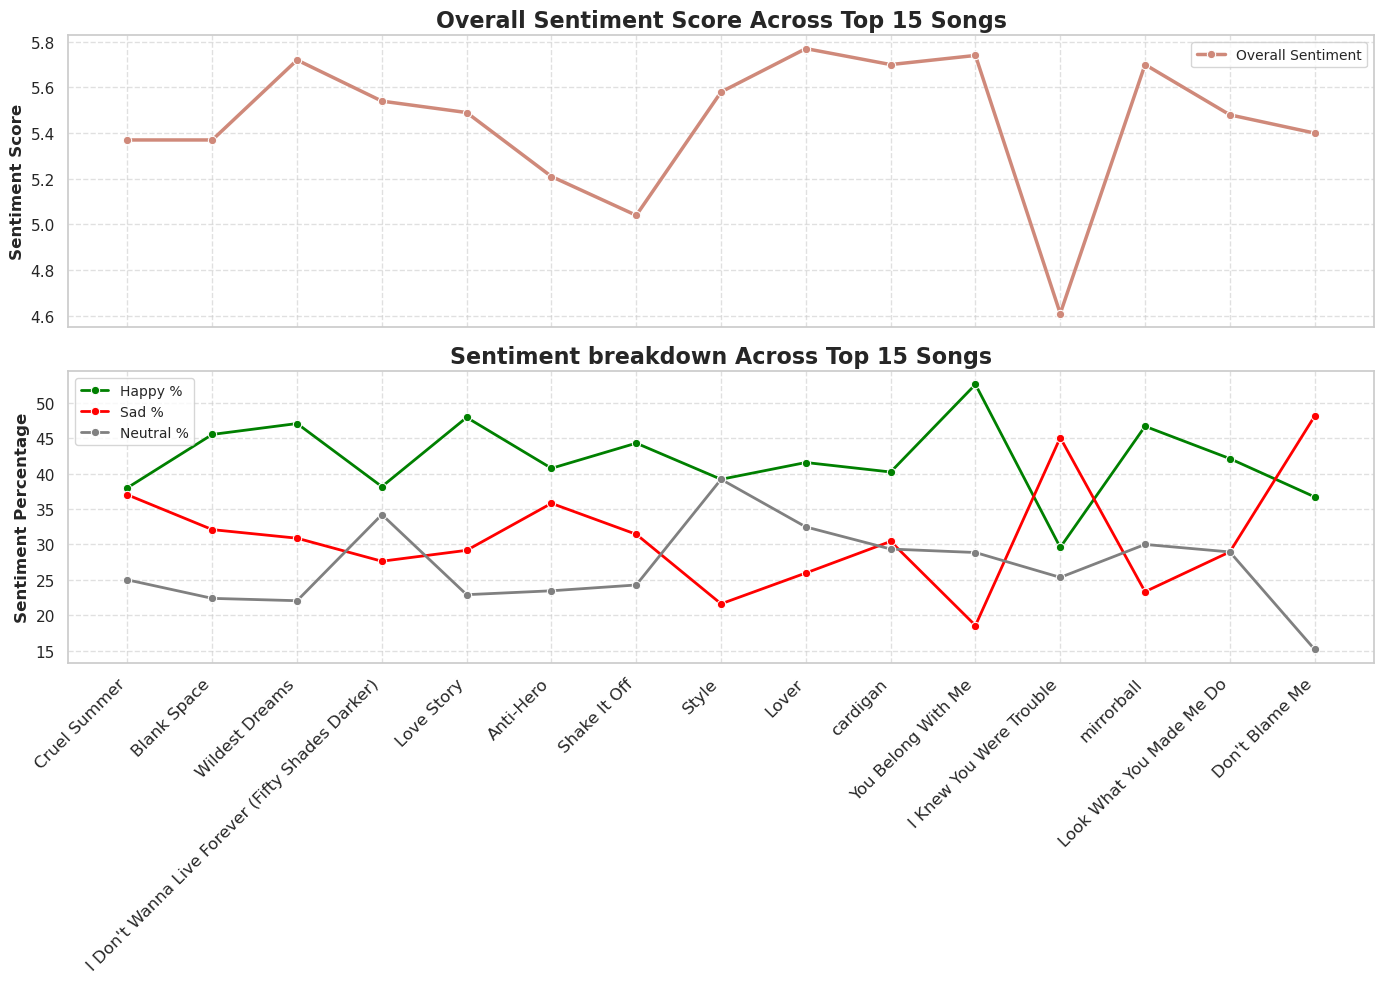

In [72]:
#plot the sentiment analysis of the top 15 songs
sentiment_df = sentiment_df.head(15)
songs = sentiment_df["Song"]
happy = sentiment_df["Happy %"]
sad = sentiment_df["Sad %"]
neutral = sentiment_df["Neutral %"]
sentiment = sentiment_df["Sentiment"]

# Set the Seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

# Create a subplot figure
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot overall sentiment score
sns.lineplot(
    ax=axes[0],
    x=songs,
    y=sentiment,
    marker="o",
    color="#cf897a",
    label="Overall Sentiment",
    linewidth=2.5
)
axes[0].set_title("Overall Sentiment Score Across Top 15 Songs", fontsize=16, weight="bold")
axes[0].set_ylabel("Sentiment Score", fontsize=12, weight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, linestyle="--", alpha=0.6)

# Plot happy, sad, and neutral percentages
sns.lineplot(ax=axes[1], x=songs, y=happy, marker="o", label="Happy %", color="green", linewidth=2)
sns.lineplot(ax=axes[1], x=songs, y=sad, marker="o", label="Sad %", color="red", linewidth=2)
sns.lineplot(ax=axes[1], x=songs, y=neutral, marker="o", label="Neutral %", color="gray", linewidth=2)

axes[1].set_title("Sentiment breakdown Across Top 15 Songs", fontsize=16, weight="bold")
axes[1].set_ylabel("Sentiment Percentage", fontsize=12, weight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, linestyle="--", alpha=0.6)

axes[1].set_xlabel("")  

# Adjust x-axis for both plots
plt.xticks(rotation=45, ha="right", fontsize=12)

# Enhance layout and spacing
plt.tight_layout()

# Display the plot
plt.show()


The overall sentiment analysis, as shown in the top graph, reveals the general emotional tone of Taylor Swift's top 15 songs, with sentiment scores ranging between approximately 4.6 and 5.8, highlighting a significant variation in mood across the tracks. Songs such as "Shake It Off" and "Blank Space" stand out with high sentiment scores exceeding 5.5, reflecting their upbeat and celebratory themes characterized by empowering and joyful narratives. In contrast, tracks like "mirrorball" display the lowest sentiment score (4.6), indicating a more somber and reflective tone that delves deeply into themes of personal vulnerability and heartbreak.

The sentiment composition analysis of the songs reveals a breakdown of happy, sad, and neutral sentiments, highlighting the emotional layers in each track. 
Happy sentiments dominate the majority of the songs, often exceeding 40% in tracks like "You belong with me" and "Wildest Dreams" reflecting their optimistic and empowering nature. This prevalence of happy sentiments aligns with the artist's signature style of creating empowering, uplifting music that connects with a wide audience. 

In contrast, sad sentiments are more prominent in certain tracks, such as "I knew you were trouble" and "Don’t Blame Me" where they surpass 40%, exploring themes of introspection, heartbreak, and emotional struggle, catering to listeners seeking a more melancholic tone. Overall, the plot shows an inverse relationship between happy and sad sentiments, with one often rising as the other falls. 

Neutral sentiments remain relatively consistent, providing a grounding element that balances the emotional intensity of the tracks. These neutral sentiments likely reflect lyrical complexity, subtle storytelling, or instrumental arrangements that introduce moderation and refinement.

<a id='popularity'></a>
## Popularity and Critical Reception

<a id='correlation-streams-sentiment'></a>
### Spotify Streams vs. Sentiment Scores

Moreover, we want to study the possible relation between the sentiment of the songs and the number of streams to see if one influences the other one.

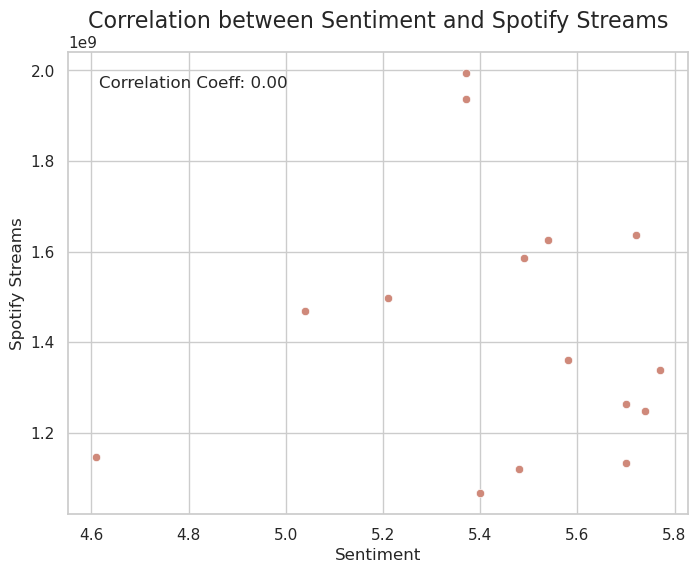

In [73]:
# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(sentiment_df['Sentiment'], sentiment_df['spotify_streams'])[0, 1]

# Correlation plot between the Sentiment and the spotify streams
plt.figure(figsize=(8, 6))
sns.scatterplot(data=sentiment_df, x='Sentiment', y='spotify_streams', color='#cf897a')
plt.title('Correlation between Sentiment and Spotify Streams', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Spotify Streams', fontsize=12)

# Add the correlation coefficient to the plot
plt.text(0.05, 0.95, f'Correlation Coeff: {correlation_coefficient:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

In this plot, it can be seen a lack of a clear pattern. This suggests that there is no strong correlation between the sentiment of the lyrics and the number of streams a song receives. However, songs with slightly higher sentiment scores (around 5.4 to 5.8) tend to be more popular. This could suggest that listeners might prefer songs that have this certain level of sentiment. Some outliers with very high streams (above 1 billion) appear too in the scatter plot.

For this reason, we decide to investigate in more detail the sentiment of each song, taking into account the percentages of happy, sad and neutral words.

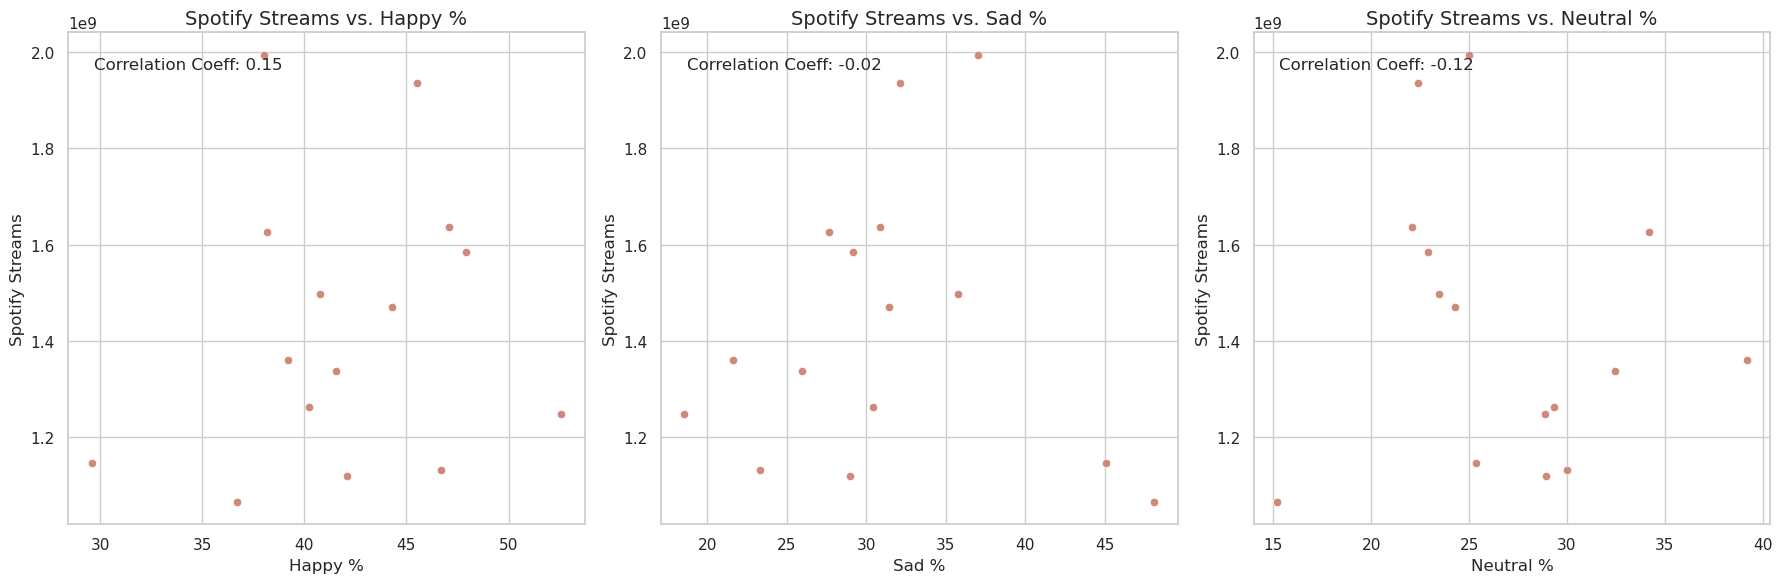

In [74]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot correlation between Spotify streams and percentage of happy words
sns.scatterplot(data=sentiment_df, x='Happy %', y='spotify_streams', color='#cf897a', ax=axes[0])
axes[0].set_title('Spotify Streams vs. Happy %', fontsize=14)
axes[0].set_xlabel('Happy %', fontsize=12)
axes[0].set_ylabel('Spotify Streams', fontsize=12)
happy_corr = np.corrcoef(sentiment_df['Happy %'], sentiment_df['spotify_streams'])[0, 1]
axes[0].text(0.05, 0.95, f'Correlation Coeff: {happy_corr:.2f}', transform=axes[0].transAxes, fontsize=12, verticalalignment='top')

# Plot correlation between Spotify streams and percentage of sad words
sns.scatterplot(data=sentiment_df, x='Sad %', y='spotify_streams', color='#cf897a', ax=axes[1])
axes[1].set_title('Spotify Streams vs. Sad %', fontsize=14)
axes[1].set_xlabel('Sad %', fontsize=12)
axes[1].set_ylabel('Spotify Streams', fontsize=12)
sad_corr = np.corrcoef(sentiment_df['Sad %'], sentiment_df['spotify_streams'])[0, 1]
axes[1].text(0.05, 0.95, f'Correlation Coeff: {sad_corr:.2f}', transform=axes[1].transAxes, fontsize=12, verticalalignment='top')

# Plot correlation between Spotify streams and percentage of neutral words
sns.scatterplot(data=sentiment_df, x='Neutral %', y='spotify_streams', color='#cf897a', ax=axes[2])
axes[2].set_title('Spotify Streams vs. Neutral %', fontsize=14)
axes[2].set_xlabel('Neutral %', fontsize=12)
axes[2].set_ylabel('Spotify Streams', fontsize=12)
neutral_corr = np.corrcoef(sentiment_df['Neutral %'], sentiment_df['spotify_streams'])[0, 1]
axes[2].text(0.05, 0.95, f'Correlation Coeff: {neutral_corr:.2f}', transform=axes[2].transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.show()

It can be seen that in the first two correlation plots (Happy and Sad) there is a weak positive correlation, and since the dispersion of data points is high, these two sentiment percentage do not significantly influence the number of streams. In the third plot, there is a slight tendency for songs with higher neutral sentiment percentages to have fewer streams. However, this correlation is still weak with dispersed data points.

In summary, all of this suggests that sentiment alone is not a strong predictor of a song's popularity. Also, we can see a presence of outliers and wide dispersion in the plots indicating that there are songs with high streams regardless of their sentiment composition. 

<a id='correlation-streams-metacritic'></a>
### Spotify Streams vs. Metacritic Scores

First, we will go through the original dataset. We will only keep the songs that are included in the albums that we have reviews for. 
To be able to do this, we first need to know the albums that are available in metacritic.

In [75]:
avg_scores = {}
for album in os.listdir("./data/album_reviews"):
    df = pd.read_csv(f"./data/album_reviews/{album}")
    avg_score = df['score'].mean()
    avg_scores[album.split(".")[0].replace("_", " ")] = avg_score

We need to process the names of the albums in the metacritics and keys dict files so that they are the same as in the dataset.

In [76]:
new_keys = list(avg_scores.keys())
for album in avg_scores.keys():
    if "THE TORTURED" in album:
        #change to lower case from the second letter for each word
        words = album.split(" ")
        new = ""
        for w in words:
            #keep the first letter and change the rest to lower case
            new += w[0] + w[1:].lower() + " "
        #remove the last space
        new = new[:-1]
        #replace the album name
        new_keys[new_keys.index(album)] = new

#change the keys of the dict
avg_scores = dict(zip(new_keys, avg_scores.values()))

We now can clean the dataset to keep only the songs that we are interested in.

In [77]:
print(f'The original dataset has {len(data)} songs')
albums = data['album'].unique()

#remove the albums that are in metacritics and not in the network
albums = [x for x in albums if x in changed_albums]

# go through data and keep only the songs which album is in the new list
data = data[data['album'].isin(albums)]
print(f'The dataset with the reviewed album has {len(data)} songs')

The original dataset has 577 songs
The dataset with the reviewed album has 294 songs


In [78]:
print(data)

                               track_name track_musical_genre track_type  \
ID                                                                         
0           Fortnight (feat. Post Malone)           Synth Pop     Single   
1           The Tortured Poets Department           Synth Pop     B-Side   
2    My Boy Only Breaks His Favorite Toys           Synth Pop     B-Side   
3                                Down Bad                 R&B     B-Side   
4                         So Long, London           Synth Pop     B-Side   
..                                    ...                 ...        ...   
572                              Our Song             Country     Single   
573         I'm Only Me When I'm With You         Country Pop     B-Side   
574                             Invisible         Country Pop     B-Side   
575                A Perfectly Good Heart         Country Pop     B-Side   
576  Teardrops on My Guitar - Pop Version         Country Pop     B-Side   

     durati

To continue with the analysis, we will aggregate the spotify streams of each album.

In [79]:
# new dataset with each album, the average score and the number of streams of the songs in the album
metacritics_scores = pd.DataFrame(columns = ['album', 'avg_score', 'spotify_streams'])

for album in albums:
    # get the average score of the album
    avg_score = avg_scores[album]
    # get the streams of the songs in the album, remove the points and convert to int
    streams = data[data['album'] == album]['spotify_streams'].str.replace('.', '').astype(int).sum()
    
    # add all the data to the new dataset
    metacritics_scores = pd.concat([metacritics_scores, pd.DataFrame({'album': [album], 'avg_score': [avg_score], 'spotify_streams': [streams]})], ignore_index=True)

We study the correlation between the average score of the metacritics and the spotify streams.

Correlation between average score and Spotify streams: 0.09


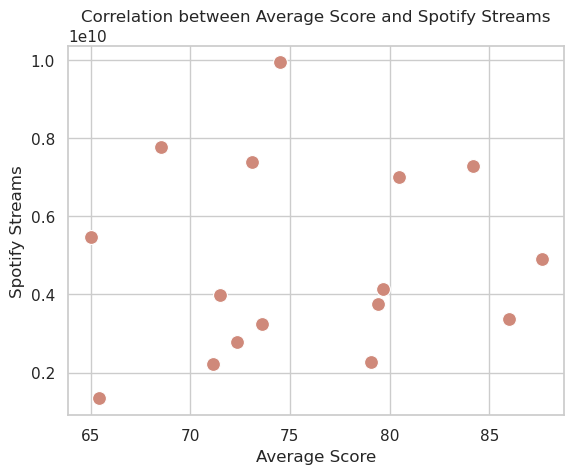

In [80]:
correlation = metacritics_scores['avg_score'].corr(metacritics_scores['spotify_streams'])
print(f'Correlation between average score and Spotify streams: {correlation:.2f}')

# Plot the data
sns.scatterplot(x='avg_score', y='spotify_streams', data=metacritics_scores, color='#cf897a', s=100)
plt.title('Correlation between Average Score and Spotify Streams')
plt.xlabel('Average Score')
plt.ylabel('Spotify Streams')
plt.show()

The scatter plot reveals no clear trend neither correlation between average scores and the number of Spotify streams. This suggests that critical acclaim, as reflected by Metacritic scores, does not strongly influence the popularity of Taylor Swift's albums on the platform. Therefore, other factors such as marketing or fan base might be more critical in driving streams.

<a id='correlation-rereleased'></a>
### Original vs. "Taylor’s Version" Albums

To better assess the impact of re-released albums on their critical scores and streaming numbers, we compared the average metacritics scores and Spotify streams of the original albums and their re-released "Taylor's Version". 

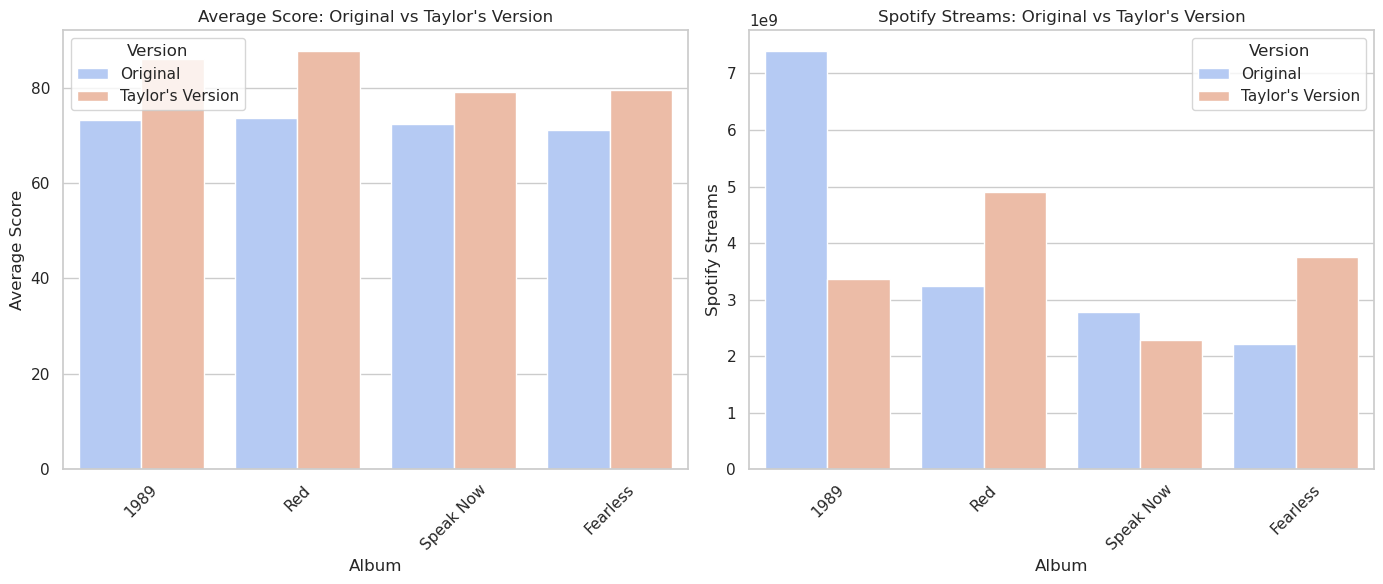

In [81]:
metacritics_scores['is_taylor_version'] = metacritics_scores['album'].str.contains("(Taylor\'s Version)")

# Separate original and re-released albums
original_albums = metacritics_scores[~metacritics_scores['is_taylor_version']].reset_index(drop=True)
taylor_versions = metacritics_scores[metacritics_scores['is_taylor_version']].reset_index(drop=True)

# only albums with both original and re-release are considered
# remove the albums that are not re-released
valid_original_albums = original_albums[original_albums['album'].isin(taylor_versions['album'].str.replace(" (Taylor\'s Version)", ""))]

# merge original albums with their re-released versions
comparison_df = pd.merge(
    valid_original_albums,
    taylor_versions,
    left_on='album',
    right_on=taylor_versions['album'].str.replace(" (Taylor's Version)", ""),
    suffixes=('_original', '_taylor_version')
)


comparison_df_melted = comparison_df.melt(id_vars='album', 
                                           value_vars=['avg_score_original', 'avg_score_taylor_version', 
                                                       'spotify_streams_original', 'spotify_streams_taylor_version'],
                                           var_name='Metric', value_name='Value')

# distinguish between original and Taylor's Version
comparison_df_melted['Version'] = comparison_df_melted['Metric'].apply(
    lambda x: 'Original' if 'original' in x else 'Taylor\'s Version')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the average score
avg_score_data = comparison_df_melted[comparison_df_melted['Metric'].str.contains('avg_score')]
sns.barplot(x='album', y='Value', hue='Version', data=avg_score_data, ax=axes[0], palette='coolwarm')
axes[0].set_title('Average Score: Original vs Taylor\'s Version')
axes[0].set_xlabel('Album')
axes[0].set_ylabel('Average Score')
axes[0].tick_params(axis='x', rotation=45)

# Plotting the spotify streams
streams_data = comparison_df_melted[comparison_df_melted['Metric'].str.contains('spotify_streams')]
sns.barplot(x='album', y='Value', hue='Version', data=streams_data, ax=axes[1], palette='coolwarm')
axes[1].set_title('Spotify Streams: Original vs Taylor\'s Version')
axes[1].set_xlabel('Album')
axes[1].set_ylabel('Spotify Streams')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In the plot on the left, we can observe the critical reception of the albums. The average Metacritic scores for the "Taylor's Version" albums are consistently higher than those for the original albums. This fact suggests that the re-released versions were more favorably received by critics, probably because they supported her with the problems she had with her old discography and they wanted to highlight Taylor Swift's inniciative and personal growth.

In the right plot, the streaming popularity of these albums can be visualized. While the original albums generally have higher total Spotify streams, probably because they have been released for more years, the "Taylor's Version" ones still achieve significant streaming numbers. This indicates that listeners are engaging with the re-released albums, reflecting their support to her. Despite the orginial albums having a head start in terms of streaming numbers, the re-released versions show a strong performance, underscoring their relevance in today's music landscape, most likely because her fans stopped listening to the old versions.

In summary, the higher Metacritic scores and substantial streaming numbers for the "Taylor's Version" albums highlight the success of Taylor Swift's re-released strategy. This also demonstrates that she has a solid fan base that are loyal to her work.